# SDTSIA210 Data Challenge - Marine Mercier & Paul Fayard

In [3]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from time import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier,StackingClassifier

from scipy.stats import uniform, randint
import scipy.stats as st

import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier 


# Introduction 

Challenge : Fusion of algorithms for face recognition

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images.

Comparing of two images is done in two steps. 1st, a vector of features is computed for each image. 2nd, a simple function produces a vector of scores for a pair of images. The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.

Note on our work: 

We both worked locally on our devices. 
As it was difficult to work on a single notebook, we decided to share the work. Everyone worked on different methods, and we regularly shared our observations and results in order to move in the same direction. 
At the end, we merged the two notebooks and obtained this one.

## Loading of the data

In [3]:
X = np.loadtxt('xtrain_challenge.csv', delimiter=',', skiprows = 1)
Y = np.loadtxt('ytrain_challenge.csv', delimiter=',', skiprows = 1)

In [4]:
#Data that we are going to predict at the end
X_exam = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)

In [5]:
np.save("X_exam.npy",X_exam)

We shuffle the data to make sure that our training/test sets are representative of the overall distribution of the data, and therefore, to make sure that we are not going to overfit on a small proportion of our data.

In [7]:
N=X.shape[0]
ordre=np.arange(0,N)
np.random.shuffle(ordre)

# Use as new variables
X=X[ordre[:]]
Y=Y[ordre[:]]

## Observation of the data

The first step of our work was to try to understand the dataset we had to work on. 
We had a total of 1,068,504 training observations from which we had to train a model to predict 3,318,296 test observations. 
Each of the training observations, corresponding to two images, has 37 features and one label: 0 or 1. The label is 1 if the two images correspond to the same person, 0 otherwise. We are thus in the case of supervised learning and more precisely of binary classification.  

In [26]:
print("The shape of the labels is ",Y.shape,".")
print("The training set consists of labels: ",np.unique(Y))
print("The shape of the observations is ",X.shape,".")
print("We work with ",X.shape[0]," data and each one has ",X.shape[1]," features.")
print("We are going to predict ",X_exam.shape[0]," new observations.")

The shape of the labels is  (1068504,) .
The training set consists of labels:  [0. 1.]
The shape of the observations is  (1068504, 37) .
We work with  1068504  data and each one has  37  features.
We are going to predict  3318296  new observations.


In [7]:
print(str(Y.mean()*100),"% of the observations have the label 1.")
print(str((1-Y.mean())*100),"% of the observations have the label 0.")

3.7054610932668477 % of the observations have the label 1.
96.29453890673315 % of the observations have the label 0.


We soon noticed that the classes were very unbalanced. 
Indeed, among the training observations, more than 96% of the data had the label 0.
We thought that we would have to adapt our algorithms to this imbalance because, it could be that our classifier only learns the majority class, and returns the label 0 for each data.

First of all, we thought we would do ***data augmentation***, i.e. create new training observations from our training observations with label 0. You'll see that Marine has worked on it in her notebook. 

On the other hand, we saw that most classifiers had a ***"class_weight" argument*** which allowed us to give more or less importance to the different classes in the loss function. Thus, we played with this parameter, penalizing more an error on a label 1 training observation than an error on a label 0 training observation. 
All we wanted to ***avoid was that our model doesn't systematically return 0***, and most classifiers didn't need this to learn something from our data.

#### Scale of the data

To get the best accuracy for our predictions, we have to work with good data. 
Our first reflex was to use a linear transformation to standardize our data (mean=0 and std=1). We applied this to the training and the test set. This avoids that some features are more important than others for no reason. We will see that it has been useful for some of our models, such as SVM or MLPClassifier. 

In [8]:
"""
# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scale=scaler.transform(X)
X_exam_scale=scaler.transform(X_exam)

"""

'\n# Scale data (each feature will have average equal to 0 and unit variance)\n\nscaler = StandardScaler()\nscaler.fit(X)\nX_scale=scaler.transform(X)\nX_exam_scale=scaler.transform(X_exam)\n\n'

#### Division of the data in training set / test set

Once we had our standardized data, the big question was: how are we going to divide our data?
Because we have over 1 million observations we knew that if we worked with all of them, the model training would be very long (espacially the choice of the hyper-parameters). 

So we made the choice to shuffle our data and to work with 1/8 of the data at the beginning, at the risk of losing a little bit of accuracy. Once the model has been chosen, we will work with all the data. 

In [9]:
N=len(X)

X_small=X[:N//8]
Y_small=Y[:N//8]

NOTE : In this notebook, we work with an eighth of the data. 

In other notebooks, we tested the different classifiers with all the data. For some models this was very time consuming, so we can't start all over again in this notebook. That's why here we work with one out of eight data, which was not the case at the time of submission.

We then divided our data into two sets, the training set, and the test set which will allow us to test our models, and above all to check that we haven't overfitted them. The latter is made up of 33% of the data retained. 

In [8]:
small=0

In [9]:
if small==1:
    
    print("To work with 1/8 of the data (to make faster training/tests).")
    X_train, X_test ,y_train, y_test = train_test_split(X_small,Y_small, test_size=0.20, random_state=42)
else:
    print("To work with all the data.") 
    X_train, X_test ,y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

To work with all the data.


## Our strategy 

After that, our approach was to test different models as we went along.
We used simple model at the beginning, but we quickly realized that, due to the number of data and the size of the features, we needed a very complex model to learn such important data.

We then compared the scores of our different classifiers, scores on the test set, to finally retain the best one.

## Useful functions

In [3]:
#To print the confusion matrix

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

classes_name=["label 0","label 1"]

In [4]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(20,15))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores, random_state", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [20]:
def submit(y_exam=None,model=None,X_exam=None):
    #save our results in a csv file
    if model !=None:
        y_exam=model.predict(X_exam)
    np.savetxt('ytest_challenge_student.csv', y_exam, fmt = '%1.0d', delimiter=',')
    

In [1]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(20,15))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores, random_state", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

## 1- First try with KNN

---

Knn is a very ***simple*** model. We use it to make a first test and see if we can draw some conclusions.

We work will 1/8 of the data because the ***prediction step is very long*** with this method, as we must evaluate such a great number of distances.

---

In [19]:
#We use the default parameters : n_neighbors=5

KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [20]:
KNN.score(X_train,y_train)

0.9979316799251287

In [22]:
s2=KNN.score(X_test,y_test)

In [24]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.72298131995657 %.


Normalized confusion matrix
[[9.99494891e-01 5.05109376e-04]
 [6.25000000e-02 9.37500000e-01]]


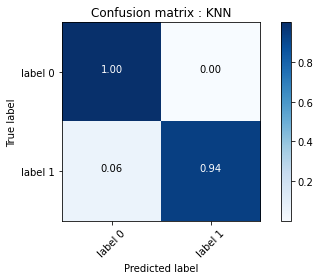

In [25]:
#Confusion matrix to analyse the faults 
y_pred=KNN.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.title("Confusion matrix : KNN")
plt.show()

Bilan : 

Dataset| Scores 
- |-: 
training set  | 99,79%
test set | 99,72% 

--- 

We see that even we a very simple model, we reach excellent scores. It predicts perfectly the class 0. There are a ***few mistakes over the label 1***, that is the minority class.

Without looking as the best parameter for n_neihbors, we are going to test directly a more complex classifier.
In fact, the KNN method is not often used because of its ***slowness***, especially for predicting large datasets like ours, and because of its inability to manage a lot of features (here 37).

The method that we are going to study next doesn't have these drawbacks.

---

## 2- Linear models : SVM

--- 

We are going to deal with a linear model, that realize predictions with a linear functions of the input features.
We know that linear models are good for very large datasets, with large dimensions, that is our case.

We have chosen SVM, one of these linear models, the one we've seen the most detail of in class.

* For this model small=0: we work with all the data because it is faster than KNN
* Here, the standardization of our data is very important. 

---

In [17]:
#Standardization of the data

mean_on_train=X_train.mean(axis=0)
std_on_train=X_train.std(axis=0)

X_train_scaled=(X_train-mean_on_train)/std_on_train
X_test_scaled=(X_test-mean_on_train)/std_on_train
X_exam_scaled=(X_exam-mean_on_train)/std_on_train

In [35]:
#Default parameters 

svm1=LinearSVC()
svm1.fit(X_train_scaled,y_train)

/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [36]:
svm1.score(X_train_scaled,y_train)

0.9981030790742244

In [37]:
s2=svm1.score(X_test_scaled,y_test)

In [38]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.80544912608089 %.


Normalized confusion matrix
[[9.99301814e-01 6.98186189e-04]
 [3.41289146e-02 9.65871085e-01]]


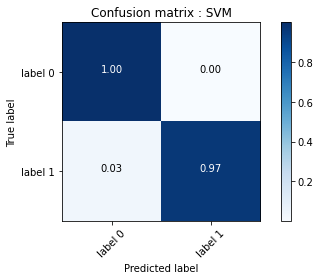

In [39]:
#Confusion matrix to analyse the faults 
y_pred=svm1.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.title("Confusion matrix : SVM")
plt.show()

Bilan : 

Dataset| Scores 
- |-: 
training set  | 99,81%
test set | 99,80% 

--- 

With default parameters, we were already getting very interesting scores.It's again a perfect for label 0, and we have improved our prediction of label 1.

We quickly understood that a sufficiently complex model was able to obtain scores higher than 99% on the test set, we would have to go for scores higher than 99.8% to stay in the competition. 

---

### Searching the best hyper-parameters

---

For the first time, we're going to go deeper into this model,by looking for the best hyper-parameters.

We are going to play on two parameters : 
 * C : Regularization parameter. The strength of the regularization is inversely proportional to C.
 * class-weight : Set the parameter C of class i to class_weight[i]*C for SVC. We see if we change stg by giving more weight to the minority class.
 
--- 

In [95]:
parameters={'C':[0.01,0.1,1],
           'class_weight': [{0:1,1:1},{0:1,1:5},{0:1,1:15}]}

Then, we search the best combination of these two parameters by doing a GridSearch with cross-validation :

In [96]:
grid = GridSearchCV(LinearSVC(), parameters)
grid.fit(X_train_scaled,y_train)

/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5},
                                          {0: 1, 1: 15}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best parameters : 

In [97]:
grid.best_params_

{'C': 0.1, 'class_weight': {0: 1, 1: 1}}

Corresponding score : 

In [98]:
grid.best_score_

0.9977985661648525

--- 

It's weird but our best score is inferior to the score we get without doing the gridsearch. With this model, tuning the parameters doesn't change a lot our scores. Also, the best parameter 'class_weights" is {0:1,1:1}, ie equal weights for each class. It means that we don't really need to adapt our algorithm to the fact that the class are unbalanced. Both class must be sufficiently weel separated. 

The big advantage of linear models is that they are very fast in terms of prediction and training. They are also able to adapt to large datasets like ours. 

So we managed to improve our score over KNN. 
However, we are still far from the 0.9985 we are now aiming for. 
In order not to waste time, and because we are eager to train more complex models, we will move directly to the next step.

Idea we could have done to improve this step: 
- do some regularization with Ridge and LASSO (but it seems useless because we don't really overfit)
- try SVM with kernels

---

In [41]:
#TO SUBMIT : 
submit(model=svm1,X_exam=X_exam_scaled)

## 3- Neural Networks

--- 

We need a more complex classifier so that our score goes up to 0,9985.
For our neural network, we chose to use the sklearn.neural_network library and the MLPClassifier model, that is very quick.

Let's do a first try without taking care of the parameters : 

(Again we work with the scaled version of our data)

---

In [43]:
mlp=MLPClassifier(hidden_layer_sizes=(15,),verbose=1,max_iter=500,random_state=0)

In [44]:
mlp.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03063585
Iteration 2, loss = 0.00673447
Iteration 3, loss = 0.00594956
Iteration 4, loss = 0.00560891
Iteration 5, loss = 0.00536448
Iteration 6, loss = 0.00522307
Iteration 7, loss = 0.00510961
Iteration 8, loss = 0.00505204
Iteration 9, loss = 0.00499033
Iteration 10, loss = 0.00494338
Iteration 11, loss = 0.00488052
Iteration 12, loss = 0.00484259
Iteration 13, loss = 0.00480436
Iteration 14, loss = 0.00478234
Iteration 15, loss = 0.00473177
Iteration 16, loss = 0.00469255
Iteration 17, loss = 0.00464473
Iteration 18, loss = 0.00461066
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [45]:
mlp.score(X_train_scaled,y_train)

0.9984550850192137

In [46]:
s2=mlp.score(X_test_scaled,y_test)

In [47]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.82359964493047 %.


Normalized confusion matrix
[[9.99540434e-01 4.59565593e-04]
 [3.54211006e-02 9.64578899e-01]]


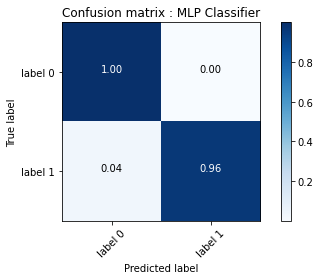

In [49]:
#Confusion matrix to analyse the faults 
y_pred=mlp.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.title("Confusion matrix : MLP Classifier")
plt.show()

Bilan : 

Dataset| Scores 
- |-: 
training set  | 99,84%
test set | 99,82% 

Without doing any gridsearch, just by testing a MLP with one layer and 15 neurons, we reach very good scores.


So we thought it was a model to dig. 
The big advantage of this model compared to the models we'll see later is that the training was very fast. 

So we have tested various parameters. 
We played with: 
- hidden_layer_sizes : the number of layer and neurons per layer
- the learning rate : constant or invscaling (gradually decreases the learning rate at each epoch)
- tol: stopping criterion, if the score has not increased by at least tol, the training stops (we change it by hand, we expect to improve the training with a very small tol)

The problem is that the parameter tuning didn't change much. 
The few times we got a score on the test set, above 99.86%, we got "only" 99.80 when submitting our model. 
Another defect is that the tol parameter can't be as small as we want. The training lasts a maximum of 70 epochs. We can't get an accuracy as small as we want to the thousandth, while every decimal place is important in this project. 

Paradoxically, the best score we submitted comes from a model whose parameters were obtained "by hand", i.e. without gridsearch.

In [17]:
res=[]
for i in range(10,200,20):
    for j in range(10,100,10):
        res.append((i,j))
    res.append((i,))

param = {
    'hidden_layer_sizes': res,
    'learning_rate':['constant','invscaling'],
    }

model = MLPClassifier(tol=0.00001,max_iter=300)

grid = RandomizedSearchCV(model, param, n_iter=50, cv=5, n_jobs=-1,verbose=1)
grid.fit(X_train_scaled, y_train)

print('The best hidden_layer_sizes is ', grid.best_params_.get('hidden_layer_sizes'),' with an average validation score equal to ', grid.best_score_)
print('It s better to work with leatning rate =', grid.best_params_.get('learning_rate'))

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test_scaled, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 40.9min finished


The best hidden_layer_sizes is  (130, 50)  with an average validation score equal to  0.9980443993179756
It s better to work with leatning rate = invscaling
The test score is 0.9977765677466195


In [18]:
mlp=MLPClassifier(hidden_layer_sizes=(130,5),learning_rate='invscaling',verbose=1,max_iter=500,random_state=0)

In [20]:
mlp.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.04328032
Iteration 2, loss = 0.00828405
Iteration 3, loss = 0.00686279
Iteration 4, loss = 0.00601021
Iteration 5, loss = 0.00533653
Iteration 6, loss = 0.00511262
Iteration 7, loss = 0.00446764
Iteration 8, loss = 0.00445541
Iteration 9, loss = 0.00431391
Iteration 10, loss = 0.00373403
Iteration 11, loss = 0.00337345
Iteration 12, loss = 0.00317996
Iteration 13, loss = 0.00285204
Iteration 14, loss = 0.00268906
Iteration 15, loss = 0.00245521
Iteration 16, loss = 0.00252386
Iteration 17, loss = 0.00236168
Iteration 18, loss = 0.00235667
Iteration 19, loss = 0.00172009
Iteration 20, loss = 0.00166245
Iteration 21, loss = 0.00134417
Iteration 22, loss = 0.00124160
Iteration 23, loss = 0.00113403
Iteration 24, loss = 0.00100340
Iteration 25, loss = 0.00096585
Iteration 26, loss = 0.00090362
Iteration 27, loss = 0.00077585
Iteration 28, loss = 0.00059776
Iteration 29, loss = 0.00145707
Iteration 30, loss = 0.00182690
Iteration 31, loss = 0.00089151
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(130, 5), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [22]:
mlp.score(X_train_scaled,y_train)

0.9996535809670678

In [23]:
mlp.score(X_test_scaled,y_test)

0.9978219439150559

In [24]:
y_pred=mlp.predict(X_test_scaled)

Normalized confusion matrix
[[9.99175073e-01 8.24926935e-04]
 [3.70145631e-02 9.62985437e-01]]


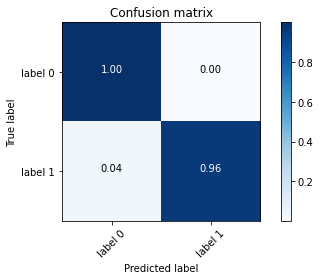

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

---

The problem is that the parameter tuning didn't change much. 

The few times we got a score on the test set above 99.86%, we got "only" 99.80 when submitting our model. 
Another defect is that the tol parameter can't be as small as we want. The training lasts a maximum of 70 epochs. We can't get an accuracy as small as we want to the thousandth, while every decimal place is important in this project. 

Paradoxically, the best score we submitted comes from a model whose parameters were obtained "by hand", i.e. without gridsearch.

In an attempt to further improve our score, we decided to learn more about the models that frequently win machine learning competitions. 
That's how we found a model that frequently seemed to be above the others, called xgboost. 

---

In [50]:
#TO SUBMIT : 
submit(model=mlp,X_exam=X_exam_scaled)

## 4- XGBOOST

---

***What is XGBoost?***

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.

It’s in fact an optimized gradient boosting algorithm through parallel processing, tree-pruning, handling missing values and regularization to avoid overfitting. XGBoost algorithm was developed as a research project at the University of Washington by Tianqi Chen and Carlos Guestrin. 

---

First we gonna test it with default parameters. We don't need to have our data scaled here, so we use X_train and not X_train scaled. 

In [51]:
t0 = time()
boost = XGBClassifier()
boost.fit(X_train,y_train)
print("Classification done in "+str(time() - t0)+"s")

Classification done in 69.51561117172241s


In [52]:
boost.score(X_train,y_train)

0.9999804441141673

In [55]:
s2=boost.score(X_test,y_test)

In [56]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.8896788776173 %.


This score is the best we've had since the beginning so we'll try to submit it right away and see what it says about the data to predict.

In [54]:
#TO SUBMIT
submit(model=boost,X_exam=X_exam)

SCORE OBTAINED : ***0.998423889852***. 

This is good but we can do better. 

Normalized confusion matrix
[[9.99578732e-01 4.21268460e-04]
 [1.86986926e-02 9.81301307e-01]]


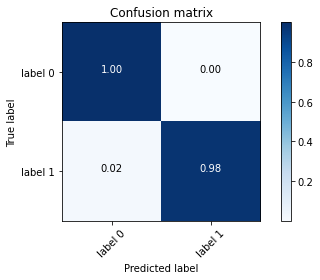

In [57]:
#Confusion matrix to analyse the faults 
y_pred=boost.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

As expected, this model, winner in many Kaggle competitions, allowed us to get good scores directly. It's the first time we achieve such score on the test sets, and especially the first time our prediction on label 1 reach 0.98.


However, xgboost has two major drawbacks: 

- its training time: on our computers, a training on all training observations could take up to 10 minutes. 

- its number of hyper-parameters to be adjusted : 
By reading on the internet tips for tuning the hyper-parameters of the xgboost, we have seen that the number of parameters to play with is 6. 

source : https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

Here is the list of parameter that we are going to examine : 

* max_depth : Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

* gamma : Minimum loss reduction required to make a further partition on a leaf node of the tree. 

* n_estimators : very important. The number of boosting stages to perform.

* learning_rate : learning rate shrinks the contribution of each tree by learning_rate.

* subsample : Subsample ratio of the training instance.

* colsample_bytree : subsample ratio of columns when constructing each tree.

In [10]:
params_fixed={'objective':'binary:logistic','silent':0}

In [11]:
params_dist_grid={
    'max_depth':range(3,10,2),
    'gamma':[0,0.5,1],
    'n_estimators':randint(30,500),
    'learning_rate':uniform(),
    'subsample':uniform(),
    'colsample_bytree':uniform()
}

By testing 6 values for each of the parameters, we obtain 6⁶=46,656 possibilities. If we count 5 minutes per iteration, we get 233,280 minutes, 3888 hours, 162 days. And still, we did not take into account that the cross validation practiced in the gridsearch took even more time than a simple training. 

In other words, it was totally impossible to test all possible parameters. 
That's why we chose to use a RandomizedGridSearchCV. With this type of approach, we choose the number of possibilities we will test. 
These will be randomly selected among the possibilities that we have entered as input. 
So we are not sure to get a maximum overall score, but the best combination of parameters will probably give a very good score. 
In terms of the number of possibilities to test, we've chosen to test 50, which is enough to keep the training running for a long afternoon.

Here is the correspondig code. It take one night to make the 50 iterations.

In [23]:
rd_grid=RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed,seed=seed),param_distributions=params_dist_grid,
n_iter=50,
cv=3,
scoring='accuracy',
random_state=seed,
verbose=10
)

In [24]:
rd_grid.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   4.3s
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.996, total=   4.2s
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   4.2s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  39.4s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   52.0s remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  39.7s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  40.0s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.2min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.998, total=  16.0s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.999, total=  16.0s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.999, total=  20.3s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.1min remaining:    0.0s


[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  31.6s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 
[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  28.2s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 
[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  29.0s
[CV] colsample_bytree=0.4636309538821305, gamma=0, learning_rate=0.7652628330253548, max_depth=3, n_estimators=217, subsample=0.005635524386628399 
[CV]  colsample_bytree=0.46363095

[CV]  colsample_bytree=0.4288656296016934, gamma=0.5, learning_rate=0.6730164898324128, max_depth=5, n_estimators=410, subsample=0.7248087016755762, score=0.999, total= 1.3min
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579, score=0.997, total=  23.7s
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579, score=0.997, total=  23.8s
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  co

[CV]  colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981, score=0.999, total=  42.5s
[CV] colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981 
[CV]  colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981, score=0.999, total=  43.5s
[CV] colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438 
[CV]  colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438, score=0.997, total=   6.4s
[CV] colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.998, total=   6.6s
[CV] colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703 
[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.998, total=   6.7s
[CV] colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703 
[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.999, total=   6.6s
[CV] colsample_bytree=0.1233781606164811, gamma=0.5, learning_rate=0.09772802614862519, max_depth=3, n_estimators=295, subsample=0.32162421002224917 
[CV]  colsample_bytree=0.1233781606164811

[CV]  colsample_bytree=0.45294600144107167, gamma=1, learning_rate=0.08303834961595746, max_depth=7, n_estimators=187, subsample=0.6069127728741993, score=0.999, total=  51.9s
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962, score=0.998, total=66.2min
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962, score=0.999, total= 1.1min
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008

[CV]  colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632, score=0.998, total=  55.1s
[CV] colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632 
[CV]  colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632, score=0.998, total=  55.6s
[CV] colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713 
[CV]  colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713, score=0.999, total= 1.0min
[CV] colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713 
[CV]  colsample_bytree=0.675408669444132

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 199.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f049e0eccf8>,
                                        'max_depth'

In [25]:
rd_grid.best_score_

0.9988126784811241

The best parameters found are : 

In [26]:
rd_grid.best_params_

{'colsample_bytree': 0.5213285655977811,
 'gamma': 1,
 'learning_rate': 0.12245745743134928,
 'max_depth': 5,
 'n_estimators': 448,
 'subsample': 0.48831719352338554}

Then, we test this model, considered to be the best one : 

In [59]:
clf=XGBClassifier(colsample_bytree= 0.5213285655977811,
 gamma= 1,
 learning_rate= 0.12245745743134928,
 max_depth= 5,
 n_estimators= 448,
 subsample= 0.48831719352338554,objective='binary:logistic')

In [60]:
clf.fit(X,Y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5213285655977811, gamma=1,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.12245745743134928, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=448, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.48831719352338554,
              tree_method=None, validate_parameters=False, verbosity=None)

In [61]:
clf.score(X_test,y_test)

0.9999319357473455

In [62]:
#TO SUBMIT : 
submit(model=clf,X_exam=X_exam)

We wanted to improve again this score, so we try the RandomizedSearchCV another night with twice more iterations.

In [14]:
rd_grid=RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed,seed=seed),param_distributions=params_dist_grid,
n_iter=100,
cv=3,
scoring='accuracy',
random_state=seed,
verbose=10
)

In [15]:
rd_grid.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   3.3s
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   3.3s
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   3.3s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  36.6s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   46.5s remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  38.5s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  38.5s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.1min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.998, total=  16.4s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.3min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.999, total=  15.8s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.999, total=  15.9s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.9min remaining:    0.0s


[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  27.5s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 
[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  27.8s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 
[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  28.5s
[CV] colsample_bytree=0.4636309538821305, gamma=0, learning_rate=0.7652628330253548, max_depth=3, n_estimators=217, subsample=0.005635524386628399 
[CV]  colsample_bytree=0.46363095

[CV]  colsample_bytree=0.4288656296016934, gamma=0.5, learning_rate=0.6730164898324128, max_depth=5, n_estimators=410, subsample=0.7248087016755762, score=0.999, total= 1.3min
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579, score=0.997, total=  24.7s
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579, score=0.997, total=  24.9s
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  co

[CV]  colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981, score=0.999, total=  43.7s
[CV] colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981 
[CV]  colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981, score=0.999, total=  43.5s
[CV] colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438 
[CV]  colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438, score=0.997, total=   6.5s
[CV] colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.998, total=   7.1s
[CV] colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703 
[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.998, total=   7.1s
[CV] colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703 
[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.999, total=   7.1s
[CV] colsample_bytree=0.1233781606164811, gamma=0.5, learning_rate=0.09772802614862519, max_depth=3, n_estimators=295, subsample=0.32162421002224917 
[CV]  colsample_bytree=0.1233781606164811

[CV]  colsample_bytree=0.45294600144107167, gamma=1, learning_rate=0.08303834961595746, max_depth=7, n_estimators=187, subsample=0.6069127728741993, score=0.999, total=  53.0s
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962, score=0.999, total= 1.1min
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962, score=0.999, total= 1.1min
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008

[CV]  colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632, score=0.998, total=  53.9s
[CV] colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632 
[CV]  colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632, score=0.998, total=  54.4s
[CV] colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713 
[CV]  colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713, score=0.999, total= 1.0min
[CV] colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713 
[CV]  colsample_bytree=0.675408669444132

[CV]  colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251, score=0.996, total=   7.0s
[CV] colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251 
[CV]  colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251, score=0.995, total=   6.9s
[CV] colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251 
[CV]  colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251, score=0.995, total=   6.8s
[CV] colsample_bytree=0.4660191122328683, gamma=0.5, learning_rate=0.2721599325974995, max_depth=5, n_estimators=184, subsample=0.7718717535091743 
[CV]  colsample_bytree=

[CV]  colsample_bytree=0.8997330149392108, gamma=0.5, learning_rate=0.3835247744746083, max_depth=5, n_estimators=356, subsample=0.7052102240395378, score=0.999, total= 2.0min
[CV] colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892 
[CV]  colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892, score=0.997, total=  26.1s
[CV] colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892 
[CV]  colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892, score=0.997, total=  27.4s
[CV] colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892 
[CV]  colsample_bytree=0.827

[CV]  colsample_bytree=0.33627139494857383, gamma=0.5, learning_rate=0.24389578673746937, max_depth=3, n_estimators=180, subsample=0.5248144499730755, score=0.999, total=  23.5s
[CV] colsample_bytree=0.33627139494857383, gamma=0.5, learning_rate=0.24389578673746937, max_depth=3, n_estimators=180, subsample=0.5248144499730755 
[CV]  colsample_bytree=0.33627139494857383, gamma=0.5, learning_rate=0.24389578673746937, max_depth=3, n_estimators=180, subsample=0.5248144499730755, score=0.999, total=  23.5s
[CV] colsample_bytree=0.8258550253895973, gamma=0.5, learning_rate=0.2522783789438505, max_depth=9, n_estimators=70, subsample=0.9167099703054473 
[CV]  colsample_bytree=0.8258550253895973, gamma=0.5, learning_rate=0.2522783789438505, max_depth=9, n_estimators=70, subsample=0.9167099703054473, score=0.999, total=  37.7s
[CV] colsample_bytree=0.8258550253895973, gamma=0.5, learning_rate=0.2522783789438505, max_depth=9, n_estimators=70, subsample=0.9167099703054473 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684, score=0.998, total= 1.0min
[CV] colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684 
[CV]  colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684, score=0.999, total= 1.0min
[CV] colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684 
[CV]  colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684, score=0.999, total= 1.0min
[CV] colsample_bytree=0.5139404691578969, gamma=0.5, learning_rate=0.2999675136645916, max_depth=9, n_estimators=278, subsample=0.8277418366554766 
[CV]  colsample_bytree=0.51394046

[CV]  colsample_bytree=0.9564638424139361, gamma=0, learning_rate=0.28181496645949267, max_depth=7, n_estimators=425, subsample=0.3361040265850367, score=0.999, total= 2.4min
[CV] colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654 
[CV]  colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654, score=0.997, total=  32.4s
[CV] colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654 
[CV]  colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654, score=0.997, total=  32.0s
[CV] colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654 
[CV]  colsample_bytree=0.3625

[CV]  colsample_bytree=0.5060506125373518, gamma=0.5, learning_rate=0.64099934659491, max_depth=9, n_estimators=166, subsample=0.3027654384906646, score=0.998, total=  42.4s
[CV] colsample_bytree=0.5060506125373518, gamma=0.5, learning_rate=0.64099934659491, max_depth=9, n_estimators=166, subsample=0.3027654384906646 
[CV]  colsample_bytree=0.5060506125373518, gamma=0.5, learning_rate=0.64099934659491, max_depth=9, n_estimators=166, subsample=0.3027654384906646, score=0.998, total=  43.7s
[CV] colsample_bytree=0.9983862721241882, gamma=0.5, learning_rate=0.2159654911802783, max_depth=5, n_estimators=232, subsample=0.9385444349357669 
[CV]  colsample_bytree=0.9983862721241882, gamma=0.5, learning_rate=0.2159654911802783, max_depth=5, n_estimators=232, subsample=0.9385444349357669, score=0.999, total= 1.4min
[CV] colsample_bytree=0.9983862721241882, gamma=0.5, learning_rate=0.2159654911802783, max_depth=5, n_estimators=232, subsample=0.9385444349357669 
[CV]  colsample_bytree=0.998386272

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 257.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc68131c710>,
                                        'max_depth'

Here are our new best parameters : 

In [19]:
rd_grid.best_params_

{'colsample_bytree': 0.9983862721241882,
 'gamma': 0.5,
 'learning_rate': 0.2159654911802783,
 'max_depth': 5,
 'n_estimators': 232,
 'subsample': 0.9385444349357669}

Let's compare them to the parameters found the night before : 

{'colsample_bytree': 0.5213285655977811,
 'gamma': 1,
 'learning_rate': 0.12245745743134928,
 'max_depth': 5,
 'n_estimators': 448,
 'subsample': 0.48831719352338554}
 
The max_depth of the trees is the same, 5.

This model considers less estimators (232 vs 448) but for each iterator, the subsample ratio of the training instance picked is largely superior as the subsample ratio of columns when constructing each tree..

We test this new model :

In [68]:
clf=XGBClassifier(colsample_bytree= 0.9983862721241882,
 gamma= 0.5,
 learning_rate= 0.2159654911802783,
 max_depth= 5,
 n_estimators= 232,
 subsample= 0.9385444349357669,objective='binary:logistic')

In [69]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9983862721241882,
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.2159654911802783,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=232, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9385444349357669, tree_method=None,
              validate_parameters=False, verbosity=None)

In [70]:
clf.score(X_test,y_test)

0.9983664579362919

In [ ]:
#TO SUBMIT : 
submit(model=clf,X_exam=X_exam)

This is currently our best score : ***0.998519119452***.

## 5- Going further 

### Ensemble methods 

---

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Marine is going to deal with ensemble methods as Adaboost or Random forests and I'm going to try Voting Classifier and Stacking.

---

#### Voting Classifier

---

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

source : https://scikit-learn.org/stable/modules/ensemble.html

First I'm going to try with 3 models :

I needed another very good classifier to be able to implement this VotingClassifier technique. 
So I used LightGBM, another gradient boosting framework that uses tree based learning algorithms, to see if the combination of the two could be more efficient.

---

In [18]:
clf1 = MLPClassifier(hidden_layer_sizes=(15,),verbose=1,max_iter=500,random_state=0)

clf2 = XGBClassifier(colsample_bytree= 0.5213285655977811,
 gamma= 1,
 learning_rate= 0.12245745743134928,
 max_depth= 5,
 n_estimators= 448,
 subsample= 0.48831719352338554,objective='binary:logistic')

clf3 = LGBMClassifier(boosting_type='goss', num_leaves=100,learning_rate=0.1, tree_method='gpu_hist',tree_learner='data',
                                                   n_estimators=300, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=64,
                                                   subsample=0.79,colsample_bytree=0.73, reg_alpha=0.0,reg_lambda= 0.0,
                                                   n_jobs= 5,subsample_for_bin =100000)

I'm going to try voting='hard' and voting='soft'

 - In majority voting (voting='hard'), the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier.
 - In contrast to majority voting (hard voting), soft voting returns the class label as argmax of the sum of predicted probabilities.

In [61]:
eclf = VotingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('lgbm', clf3)],voting='hard')

In [65]:
eclf.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03063585
Iteration 2, loss = 0.00673447
Iteration 3, loss = 0.00594956
Iteration 4, loss = 0.00560891
Iteration 5, loss = 0.00536448
Iteration 6, loss = 0.00522307
Iteration 7, loss = 0.00510961
Iteration 8, loss = 0.00505204
Iteration 9, loss = 0.00499033
Iteration 10, loss = 0.00494338
Iteration 11, loss = 0.00488052
Iteration 12, loss = 0.00484259
Iteration 13, loss = 0.00480436
Iteration 14, loss = 0.00478234
Iteration 15, loss = 0.00473177
Iteration 16, loss = 0.00469255
Iteration 17, loss = 0.00464473
Iteration 18, loss = 0.00461066
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


VotingClassifier(estimators=[('mlp',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(15,),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=500,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=0,
                                            shuffl...
                                             learning_rate=0.1, max_depth=-1,
                                    

In [66]:
s2=eclf.score(X_test_scaled,y_test)

In [67]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.89223129433051 %.


Normalized confusion matrix
[[9.99614083e-01 3.85917261e-04]
 [1.89267254e-02 9.81073275e-01]]


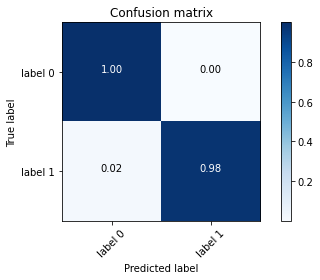

In [68]:
#Confusion matrix to analyse the faults 
y_pred=eclf.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

In [69]:
#TO SUBMIT
submit(model=eclf,X_exam=X_exam_scaled)

SCORE : ***0,99850***

With voting = 'soft'

In [70]:
eclf2 = VotingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('lgbm', clf3)],voting='soft')

In [71]:
eclf2.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03063585
Iteration 2, loss = 0.00673447
Iteration 3, loss = 0.00594956
Iteration 4, loss = 0.00560891
Iteration 5, loss = 0.00536448
Iteration 6, loss = 0.00522307
Iteration 7, loss = 0.00510961
Iteration 8, loss = 0.00505204
Iteration 9, loss = 0.00499033
Iteration 10, loss = 0.00494338
Iteration 11, loss = 0.00488052
Iteration 12, loss = 0.00484259
Iteration 13, loss = 0.00480436
Iteration 14, loss = 0.00478234
Iteration 15, loss = 0.00473177
Iteration 16, loss = 0.00469255
Iteration 17, loss = 0.00464473
Iteration 18, loss = 0.00461066
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


VotingClassifier(estimators=[('mlp',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(15,),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=500,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=0,
                                            shuffl...
                                             learning_rate=0.1, max_depth=-1,
                                    

In [72]:
s2=eclf2.score(X_test_scaled,y_test)

In [73]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.89308209990159 %.


Normalized confusion matrix
[[9.99643542e-01 3.56457928e-04]
 [1.94588021e-02 9.80541198e-01]]


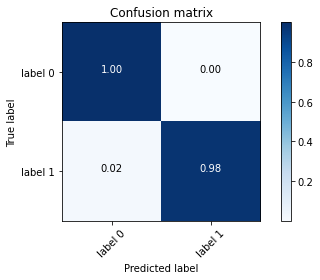

In [74]:
#Confusion matrix to analyse the faults 
y_pred=eclf2.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

In [75]:
#TO SUBMIT
submit(model=eclf2,X_exam=X_exam_scaled)

SCORE : ***0.99854***, a little better

Last try with weights : 2 for the better, 1 for the worst, 1.5 for the other.

In [77]:
eclf3 = VotingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('lgbm', clf3)],voting='soft',weights=[1, 1.5, 2])

In [78]:
eclf3.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03063585
Iteration 2, loss = 0.00673447
Iteration 3, loss = 0.00594956
Iteration 4, loss = 0.00560891
Iteration 5, loss = 0.00536448
Iteration 6, loss = 0.00522307
Iteration 7, loss = 0.00510961
Iteration 8, loss = 0.00505204
Iteration 9, loss = 0.00499033
Iteration 10, loss = 0.00494338
Iteration 11, loss = 0.00488052
Iteration 12, loss = 0.00484259
Iteration 13, loss = 0.00480436
Iteration 14, loss = 0.00478234
Iteration 15, loss = 0.00473177
Iteration 16, loss = 0.00469255
Iteration 17, loss = 0.00464473
Iteration 18, loss = 0.00461066
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


VotingClassifier(estimators=[('mlp',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(15,),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=500,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=0,
                                            shuffl...
                                             learning_rate=0.1, max_depth=-1,
                                    

In [80]:
s2=eclf3.score(X_test_scaled,y_test)

In [87]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.8964853221859 %.


Normalized confusion matrix
[[9.99631758e-01 3.68241661e-04]
 [1.82426269e-02 9.81757373e-01]]


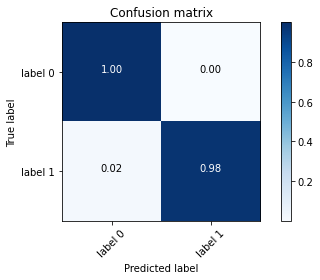

In [85]:
#Confusion matrix to analyse the faults 
y_pred=eclf3.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

In [86]:
#TO SUBMIT
submit(model=eclf3,X_exam=X_exam_scaled)

SCORE : ***0.99854*** again 

#### Stacking 

Model stacking is an efficient ensemble method in which the predictions, generated by using various machine learning algorithms, are used as inputs in a second-layer learning algorithm.

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [19]:
lf = StackingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('lgbm', clf3)], final_estimator=LogisticRegression())

In [20]:
lf.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03095447
Iteration 2, loss = 0.00692235
Iteration 3, loss = 0.00606835
Iteration 4, loss = 0.00571230
Iteration 5, loss = 0.00545106
Iteration 6, loss = 0.00526997
Iteration 7, loss = 0.00512936
Iteration 8, loss = 0.00501429
Iteration 9, loss = 0.00494212
Iteration 10, loss = 0.00488490
Iteration 11, loss = 0.00486955
Iteration 12, loss = 0.00482306
Iteration 13, loss = 0.00477022
Iteration 14, loss = 0.00474189
Iteration 15, loss = 0.00468041
Iteration 16, loss = 0.00466272
Iteration 17, loss = 0.00461631
Iteration 18, loss = 0.00458956
Iteration 19, loss = 0.00456402
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.03646747
Iteration 2, loss = 0.00728592
Iteration 3, loss = 0.00629184
Iteration 4, loss = 0.00584611
Iteration 5, loss = 0.00560648
Iteration 6, loss = 0.00538092
Iteration 7, loss = 0.00517056
Iteration 8, loss = 0.00512061
Iteration 9, loss = 0.00500289
Iteration 10, loss = 0.00489919


StackingClassifier(cv=None,
                   estimators=[('mlp',
                                MLPClassifier(activation='relu', alpha=0.0001,
                                              batch_size='auto', beta_1=0.9,
                                              beta_2=0.999,
                                              early_stopping=False,
                                              epsilon=1e-08,
                                              hidden_layer_sizes=(15,),
                                              learning_rate='constant',
                                              learning_rate_init=0.001,
                                              max_fun=15000, max_iter=500,
                                              momentum=0.9, n_iter_no_change=10,
                                              nesterovs_momentum=True,
                                              power_t=0.5, random_stat...
                                               tree_learner='data',
   

In [21]:
s2=lf.score(X_test_scaled,y_test)

In [22]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.89620172032888 %.


Normalized confusion matrix
[[9.99661218e-01 3.38782328e-04]
 [2.09790210e-02 9.79020979e-01]]


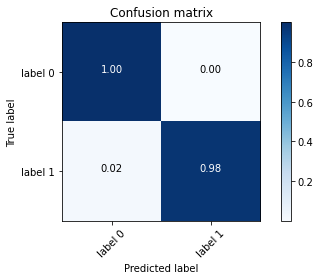

In [97]:
#Confusion matrix to analyse the faults 
y_pred=lf.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

In [23]:
#TO SUBMIT
submit(model=lf,X_exam=X_exam_scaled)

SCORE : ***0.998564926095*** our best score ! 

## Now : Marine's work 

We soon noticed that the classes were very unbalanced.
Indeed, among the training observations, more than 96% of the data had the label 0.
We thought that we would have to adapt our algorithms to this imbalance because, it could be that our classifier only learns the majority class, and returns the label 0 for each data.
First of all, we thought we would do data augmentation, i.e. create new training observations from our training observations with label 0.


In [8]:
# Oversample and plot imbalanced dataset with SMOTE

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

oversample1 = SMOTE(sampling_strategy=0.2)
x_smote, y_smote = oversample1.fit_resample(x_train_scale, y_train)

oversample2 = RandomOverSampler(sampling_strategy=0.2)
x_overs,y_overs=oversample2.fit_resample(x_train_scale, y_train)

under1 = RandomUnderSampler(sampling_strategy=0.5)
x_sample1,y_sample1=under1.fit_resample(x_smote,y_smote)

under2 = RandomUnderSampler(sampling_strategy=0.5)
x_sample2,y_sample2=under2.fit_resample(x_overs,y_overs)

To to resolve the imbalance problem we use the following algorithms:
- The SMOTE algorithm artificially generates instances of the minority class based on the closest neighbors. 
- UnderSampling removes some instances of the majority class. 
- OverSampling multiplies the instances of the minority class in order to have repetitions.

We test two different ways to increase the number of minority data. The first one is the combination of SMOTE, and UnderSampling. The second is the combination of OverSampling and UnderSampling.

## 6- Decision Tree Classifier

We start with a simple classifier. 

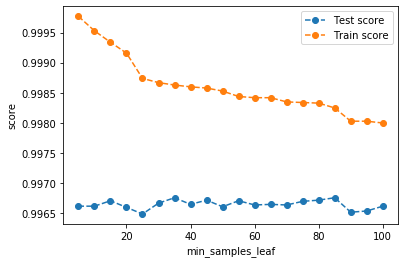

In [17]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
ab=np.linspace(1,10,10)
TTest=[]
TTrain=[]
for i in range(1,11):
  Tree = DecisionTreeClassifier(min_samples_split=i)
  Tree.fit(x_train_scale,y_train)
  TTrain.append(Tree.score(x_train_scale,y_train))
  TTest.append(Tree.score(x_test_scale,y_test))
    
plt.plot(ab,TTest,linestyle='--',marker='o',label='Test score')
plt.plot(ab,TTrain,linestyle='--',marker='o',label='Train score')
plt.xlabel("min_samples_leaf")
plt.ylabel("score")
plt.legend()

idx=TTest.index(min(TTest))
best_leaf=ab[idx]

You can see that taking a small min_number_leafs gives very different results on the test and train set. This is overfitting. 
Let's test with max_depth which allows to limit the depth of the tree. 

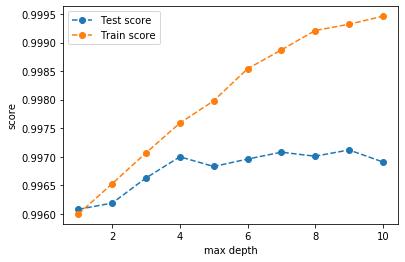

In [22]:
ab=np.linspace(1,10,10)
TTest=[]
TTrain=[]
for i in range(1,11):
  Tree = DecisionTreeClassifier(max_depth=i)
  Tree.fit(x_train_scale,y_train)
  TTrain.append(Tree.score(x_train_scale,y_train))
  TTest.append(Tree.score(x_test_scale,y_test))
    
plt.plot(ab,TTest,linestyle='--',marker='o',label='Test score')
plt.plot(ab,TTrain,linestyle='--',marker='o',label='Train score')
plt.xlabel("max depth")
plt.ylabel("score")
plt.legend()

idx=TTest.index(max(TTest))
best_depth=ab[idx]

The best result seems to be obtained for depth_max= 4. Indeed, beyond that the test score does not increase any more while the train score continues to increase. This means that beyond max_depth =4 we are overfitting. 

In [23]:
Tree1 = DecisionTreeClassifier(max_depth=best_depth)
Tree1.fit(x_train,y_train)
print("Imbalanced Dataset Not scaled")
print('Score in the training set is {0}'.format(Tree1.score(x_train,y_train)) )
print('Score in the test set is {0}'.format(Tree1.score(x_test,y_test)) )

Imbalanced Dataset Not scaled
Score in the training set is 0.99932
Score in the test set is 0.99715


In [24]:
Tree2 = DecisionTreeClassifier(max_depth=best_depth)
Tree2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",Tree2.score(x_train_scale,y_train))
print("Test score :",Tree2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99932
Test score : 0.9971


In [25]:
Tree3 = DecisionTreeClassifier(max_depth=best_depth)
Tree3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",Tree3.score(x_sample1,y_sample1))
print("Test score :",Tree3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 0.9978861281491492
Test score : 0.99443


In [26]:
Tree4 = DecisionTreeClassifier(max_depth=best_depth)   
Tree4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",Tree4.score(x_sample2,y_sample2))
print("Test score :",Tree4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.998925737256125
Test score : 0.99517


For the Simple Classify algorithm we notice that it is not useful to normalize the data. Increasing seems also useless, the results are less good when we use a driven shaft on the balanced data. Indeed SMOTE generates noise, while OverSampling encouraged overfitting. 

We therefore decide to test our data on unbalanced and non-scaled data. 

##### Submit result

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(max_depth=best_depth)
clf.fit(X,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_tree_class.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.964844004272

The score is very low, indeed 96% of the data are labeled 0, so an algorithm returning only 0's will have a score close to 0.96 if the test set has the same distribution as the train set.

## 7- Bagging

Let's use bagging to improve our weak learner's performance. Bagging consist of training many weak learners on differents data, chosen randomly. Weak learners achieve an accuracy that is just above random chance.  DecisionTreeClassifier is a weak learner. Bagging generates many Decision Tree, but each tree is created using only a part of the data, different at each time. 

n_estimators is the number of weak learner generated.

First we try with the best_tree we found at the last step (max_depth = 4).

In [36]:
from sklearn.ensemble import BaggingClassifier
Tree = DecisionTreeClassifier(max_depth=4)
p_grid_bagging = {'n_estimators': [50,75,100,150]}
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging_ = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging_.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=4,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                            

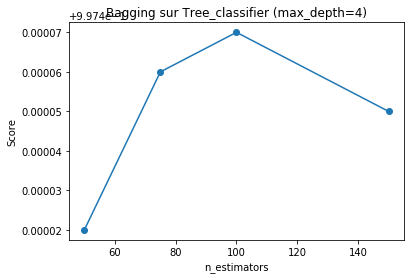

In [51]:
estimators=p_grid_bagging['n_estimators']
scores_mean = [grid_bagging_.cv_results_['mean_test_score'][i] for i in range(len(estimators))]
idx=scores_mean.index(max(scores_mean))
best_estimator_bag=p_grid_bagging['n_estimators'][idx]
plt.plot(estimators,scores_mean,marker='o')
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title('Bagging sur Tree_classifier (max_depth=4)')
plt.show()

Let's test this model on different types of data (scaled or not, balanced or not...)

In [52]:
Tree = DecisionTreeClassifier(max_depth=4)   
bag1=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag1.fit(x_train, y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",bag1.score(x_train,y_train))
print("Test score:",bag1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99806
Test score: 0.99737


In [53]:
bag2=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",bag2.score(x_train_scale,y_train))
print("Test score :",bag2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99806
Test score : 0.99737


In [54]:
bag3=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",bag3.score(x_sample1,y_sample1))
print("Test score :",bag3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 0.9946979935544236
Test score : 0.9953


In [55]:
Tree = DecisionTreeClassifier(max_depth=best_depth)   
bag4=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",bag4.score(x_sample2,y_sample2))
print("Test score :",bag4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.9986831617978307
Test score : 0.99628


#### Submit a result 

In [100]:
Tree = DecisionTreeClassifier(max_depth=4)   
clf_bag=BaggingClassifier(base_estimator=Tree,n_estimators=100, random_state=0)
clf_bag.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf_bag.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_bag.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.996794740433

We notice that for the first time, the SMOTE algorithm gets good results and does not create over-fitting. 
Indeed, the test score is higher than the training score ! Nonetheless the test score is higher on scaled and unbalanced data. 

Let's try testing other tree depths to see if we get better results.

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

depth=[2,4,6,8,10,12,14,16,18,20]
p_grid_bagging = {'n_estimators': [50,75,100,125,150,175,200]} 
score_bag=[]
parameters_bag=[]
best_score=0
save_grid_bag=[]
for i in depth:
    Tree = DecisionTreeClassifier(max_depth=i)   
    bag=BaggingClassifier(base_estimator=Tree, random_state=0)
    grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
    grid_bagging.fit(x_train, y_train)
    score_bag.append(grid_bagging.best_score_)
    parameters_bag.append(grid_bagging.best_params_)
    if grid_bagging.best_score_>best_score:
        save_grid_bag=[grid_bagging]
        best_score=grid_bagging.best_score_

Text(0.5, 1.0, 'Best GridSearch Score according to max_depth')

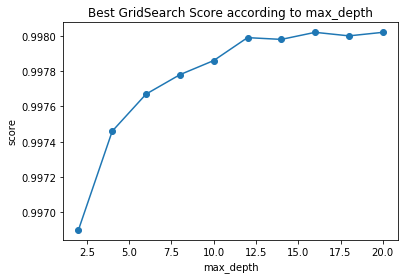

In [41]:
depth=[2,4,6,8,10,12,14,16,18,20]

idx=score_bag.index(max(score_bag))
best_depth_bag=depth[idx]
estimators_=[dic['n_estimators'] for dic in parameters_bag]
best_estimator_bag=estimators_[idx]

plt.figure()
plt.plot(depth,score_bag,marker='o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Best GridSearch Score according to max_depth')

Text(0.5, 1.0, 'Best GridSearch nb_estimator according to max_depth')

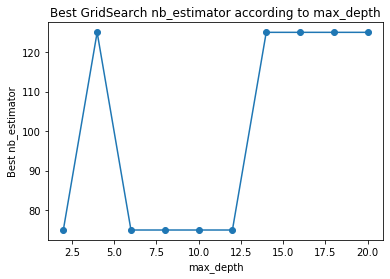

In [47]:
plt.figure()
plt.plot(depth,estimators_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best nb_estimator')
plt.title('Best GridSearch nb_estimator according to max_depth')

However it seems that the deeper the tree is, the more instances of the weak learner we need. Multiplying the instances of the weak learner increases the computing time considerably. So we have to make a compromise between precision and computation time.


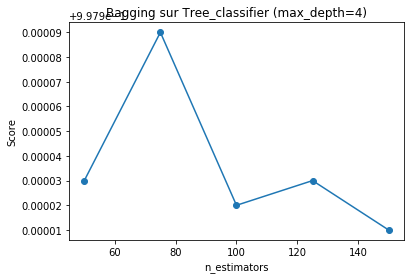

In [16]:
grid=save_grid_bag[0]
estimators=p_grid_bagging['n_estimators']
scores_mean = [grid.cv_results_['mean_test_score'][i] for i in range(len(estimators))]
idx=scores_mean.index(max(scores_mean))
best_estimator_bag=p_grid_bagging['n_estimators'][idx]
plt.plot(estimators,scores_mean,marker='o')
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title('Bagging sur Tree_classifier (max_depth=4)')
plt.show()

Let's test our best model on different types of data (scaled or not, balanced or not...)

In [17]:
Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
bag1=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag1.fit(x_train, y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",bag1.score(x_train,y_train))
print("Test score:",bag1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99956
Test score: 0.99784


In [18]:
Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
bag2=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",bag2.score(x_train_scale,y_train))
print("Test score :",bag2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99956
Test score : 0.99784


In [19]:
Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
bag3=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",bag3.score(x_sample1,y_sample1))
print("Test score :",bag3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 0.9992052797069901
Test score : 0.99601


In [20]:
Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
bag4=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",bag4.score(x_sample2,y_sample2))
print("Test score :",bag4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.9993262154037524
Test score : 0.99609


If the trees are too deep it creates some over-fitting. Indeed, the score difference between the training scores and validation score is wider. The Training sore increases a lot when we choose deeper trees, but not the validation score. 

#### Submit a Result

In [21]:

Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
clf_bag=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
clf_bag.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf_bag.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_bag.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.99788445636

## 8- AdaBoost et DecisionTreeClassifier

Adaboost generates a user-specified set of learners (otherwise it will randomly generate a set of weak learners).
AdaBoost is very efficient on weak learner. 

AdaBoost will learn the weights of how to add these weak learners to be a strong learner. The weight of each learner is learned based on whether he predicts a sample correctly or not. The weight of a learner which predicts a sample badly is reduced. This process is repeated until the algorithme converges.

Adaboost generates nb_estimators weak learners. For each weak learner created, the misclassification rate is calculated. The weight for the m-th classifier is $\theta_m = ln(\frac{1-error}{error})$. The weight is updated for each data point : $W_{m+1}(x_i,y_i) = \frac{W_m (x_i,y_i) \exp^{-\theta_m y_i f_m(xi)}}{Z} $ where Z is a normalization factor and $f_m( )$ is the m-th classifier.

The learning rate represents the contribution of each model to the weights. Reducing the learning rate forces the model to train slowly. It may help to prevent overfitting.

At first glance, it seems that using a large number of estimators and a learning rate close to 1 should give better results. So I made a first test.

In [32]:
from sklearn.ensemble import AdaBoostClassifier

depth=[1,5,10,15,20,25]
p_grid_Ada_Tree = {'n_estimators': [100,150,200],'learning_rate':[0.9,0.95,0.98],}
score_ada=[]
parameters_ada=[]
for i in depth:
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                               algorithm="SAMME")
    grid_ada_tree = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree, scoring="accuracy", cv=5)
    grid_ada_tree.fit(x_train_scale, y_train)
    score_ada.append(grid_ada_tree.best_score_)
    parameters_ada.append(grid_ada_tree.best_params_)

Text(0.5, 1.0, 'Best GridSearch Score according to max_depth')

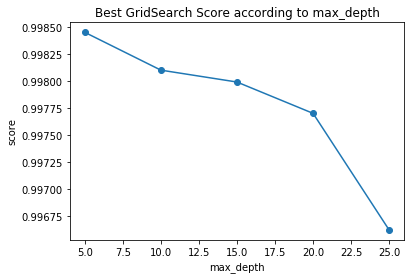

In [33]:
idx=score_ada.index(max(score_ada))
best_depth=depth[idx]
estimators_=parameters_ada['n_estimators']
lr_=parameters_ada['learning_rate']
best_estimator_=estimators_[idx]
best_lr_adaTree=lr_[idx]

plt.figure()
plt.plot(depth,score_ada,marker='o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Best GridSearch Score according to max_depth')

We can see that using a tree that is too deep immediately leads to poorer results. The simpler the weak-learner is, the more efficient AdaBoost is. Indeed, if the tree is to deep, it creates overfitting. 

Most of the time AdaBoost is tested with Decision Stump, which are trees whith one node and two leafs. 


To avoid overfitting, we can also reduce the learning rate. 
__Let's try a wider range of learning_rate.__

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

depth=[2,3,4,5,6,7]
p_grid_Ada_Tree2 = {'n_estimators': [100,150,200,250],'learning_rate':[0.1,0.3,0.5,0.7,0.9]}
score_ada2=[]
parameters_ada2=[]
best_score=0
save_grid=[]
for i in depth:
    model = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini",max_depth=i, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
    grid_ada_Tree2 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree2, scoring="accuracy", cv=5)
    grid_ada_Tree2.fit(x_train_scale, y_train)
    score_ada2.append(grid_ada_Tree2.best_score_)
    parameters_ada2.append(grid_ada_Tree2.best_params_)
    if grid_ada_Tree2.best_score_>best_score:
        save_grid=[grid_ada_tree]
        best_score=grid_ada_tree.best_score_

Text(0.5, 1.0, 'Best GridSearch Score according to max_depth')

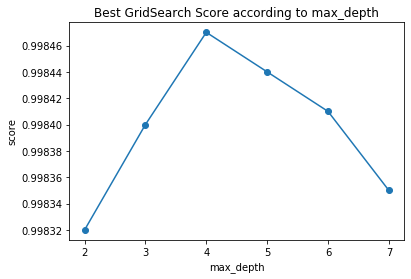

In [24]:
depth=[2,3,4,5,6,7]
idx=score_ada2.index(max(score_ada2))
best_depth=depth[idx]
estimators_=[dic['n_estimators'] for dic in parameters_ada2]
lr_=[dic['learning_rate'] for dic in parameters_ada2]
best_estimator_=estimators_[idx]
best_lr_adaTree=lr_[idx]

plt.figure()
plt.plot(depth,score_ada2,marker='o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Best GridSearch Score according to max_depth')

Text(0.5, 1.0, 'Best GridSearch nb_estimator according to max_depth')

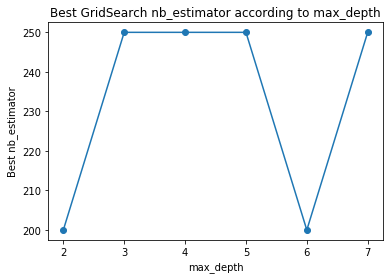

In [26]:
plt.figure()
plt.plot(depth,estimators_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best nb_estimator')
plt.title('Best GridSearch nb_estimator according to max_depth')

Text(0.5, 1.0, 'Best GridSearch learning rate according to max_depth')

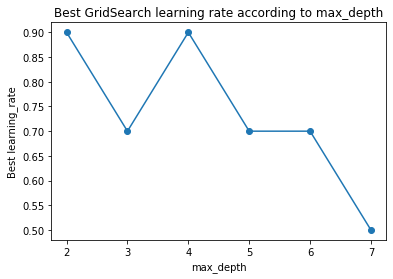

In [25]:
plt.figure()
plt.plot(depth,lr_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best learning_rate')
plt.title('Best GridSearch learning rate according to max_depth')

It seems that the best learning rate decreases when the max_depth increases. If the max_depth is large, the odds of overfitting are high. Therefore, one should choose a small learning rate, to slow the learning down.

We have chosen the best tree depth 4, let's now study the impact of learning_rate and nb_estimators. 

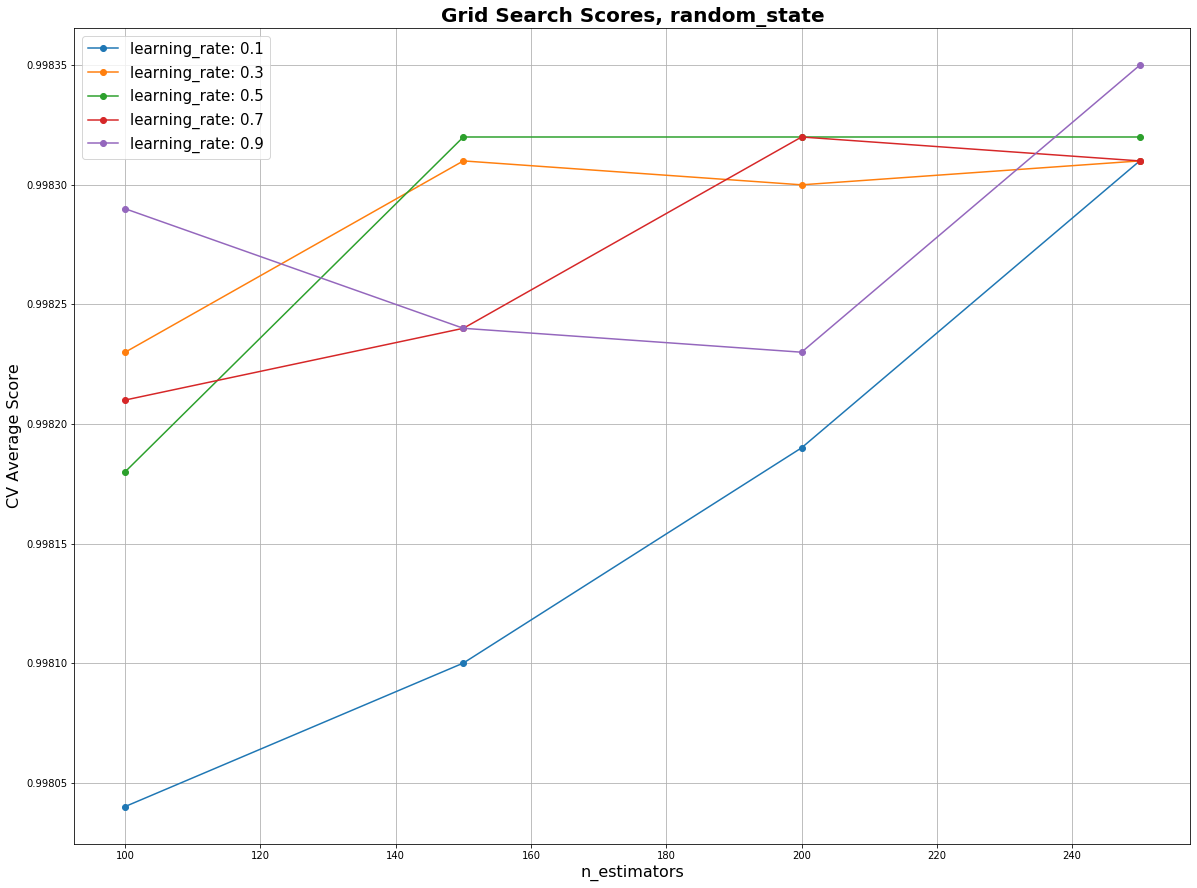

In [39]:
grid=save_grid[0]
plot_grid_search(grid.cv_results_,  p_grid_Ada_Tree2['n_estimators'],p_grid_Ada_Tree2['learning_rate'], 'n_estimators','learning_rate')

It seems that the score increases with n_estimators for most learning rates. 
If both the n_estimators and the learning rate are small, we obtain bad results. 
If the learning rate or the number of estimator is small, and the other is large, the results are not bad. 
But we get the best results chen the number of estimator and the number of 

Let's deepen our search for the best hyperparameters. We chose best_depth = 4.

Let's test the "gini" and "entropy" criterion of DecisionTreeClassifier.

### Gini Criterion

The Gini criterion measures how often a randomly chosen sample would be incorrectly classified. 

$$Gini=1-\sum_{j \in {0,1}} p_j^2$$
with $p_1$ and $p_0$ the probability to get a 1 or a 0 at each node.




In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

p_grid_Ada_Tree3 = {'n_estimators': [200,225,250],'learning_rate':[0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975,1]}

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini",max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree3 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree3, scoring="accuracy", cv=5)
grid_ada_Tree3.fit(x_train_scale, y_train)



GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
    

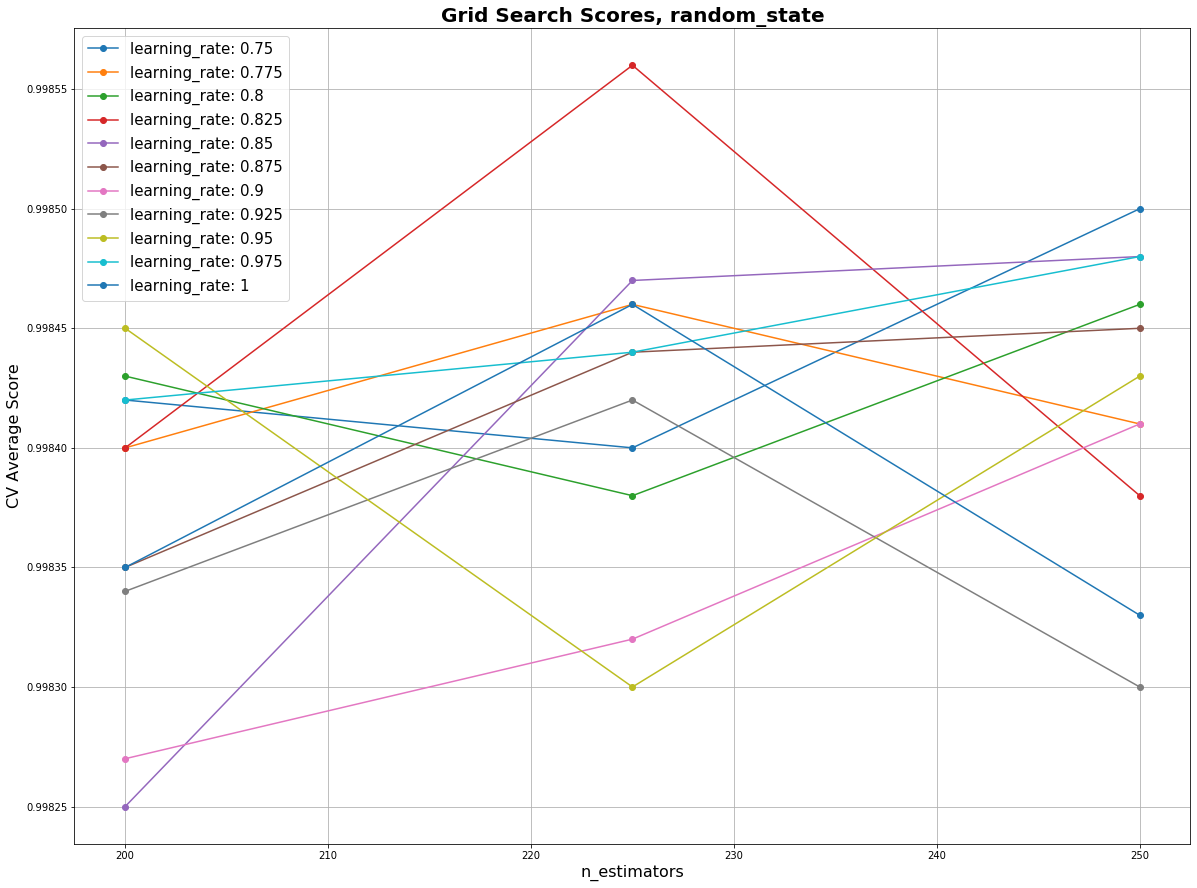

In [30]:
plot_grid_search(grid_ada_Tree3.cv_results_,  p_grid_Ada_Tree3['n_estimators'],p_grid_Ada_Tree3['learning_rate'], 'n_estimators','learning_rate')

Once again we observe that the score increase with the number of estimators for most learning_rates.

In [33]:
print("Best Score: {}".format(grid_ada_Tree3.best_score_))
print("Best params: {}".format(grid_ada_Tree3.best_params_))
best_estimator_=grid_ada_Tree3.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree3.best_params_['learning_rate']
best_depth=4

Best Score: 0.99856
Best params: {'learning_rate': 0.825, 'n_estimators': 225}


Let's test our best model on different types of data (scaled or not, balanced or not...)

In [34]:
clf1= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99826


In [35]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99826


In [36]:
clf3= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99771


In [37]:
clf4= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99798


##### Submit a result

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998017657255

### Entropy Criterion 

The Entropy Criterion uses logarithm intead of simple probabilities. It measures the information gain at each node.

$$Entropy=- \sum_{j \in {0,1}} p_j log_2 (p_j)$$

with $p_1$ and $p_0$ the probability to get a 1 or a 0 at each node.


In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

p_grid_Ada_Tree4 = {'n_estimators': [200,225,250],'learning_rate':[0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975,1]}

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree4 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree4, scoring="accuracy", cv=5)
grid_ada_Tree4.fit(x_train_scale, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

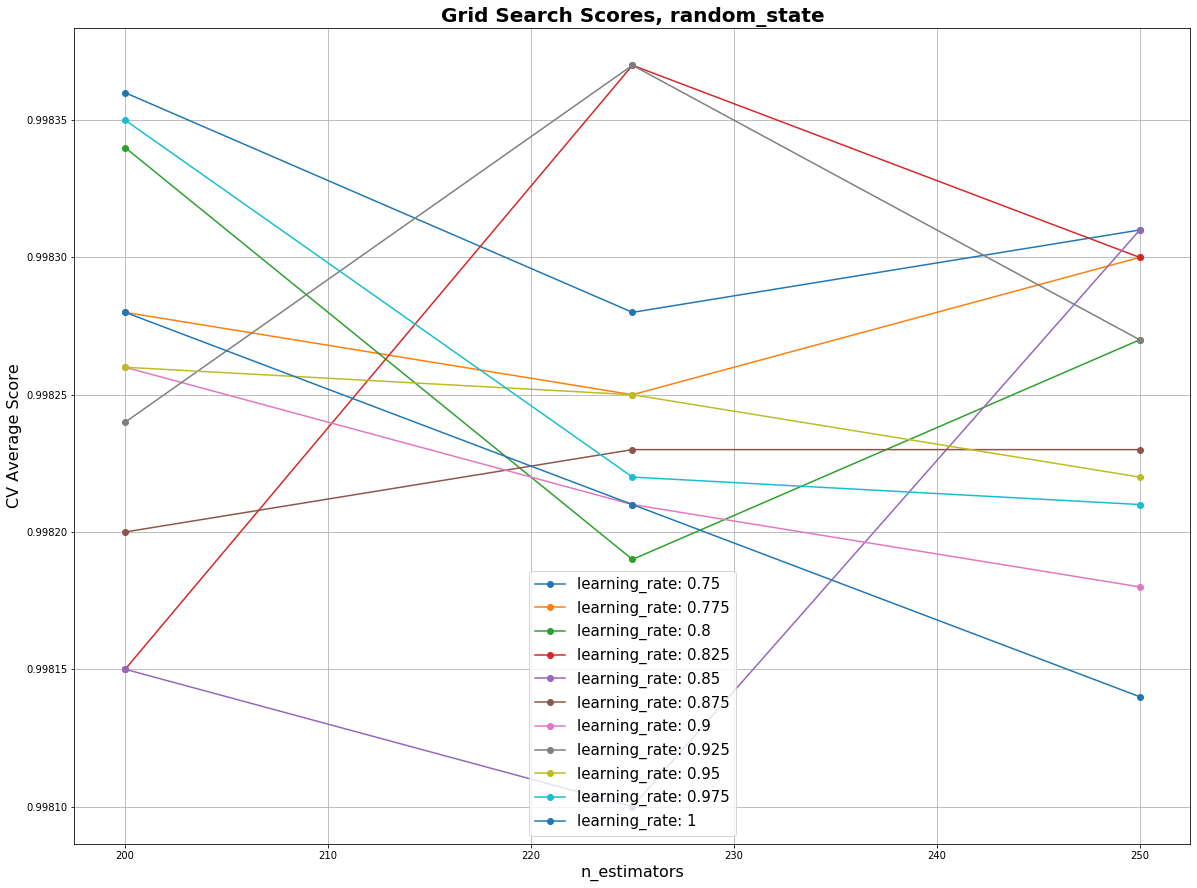

In [23]:
plot_grid_search(grid_ada_Tree4.cv_results_,  p_grid_Ada_Tree4['n_estimators'],p_grid_Ada_Tree4['learning_rate'], 'n_estimators','learning_rate')

It seems that for large learning rate, the score decreases chen the number of estimators increase. 

On the contrary, for the Gini criterion, we need more estimators to get better scores. 

If we need to use smaller number of estimators with the entropy criterion than with the gini criterion, using the entropy criterion may be useful in order to reduce computationnal time.

In [24]:
print("Best Score: {}".format(grid_ada_Tree4.best_score_))
print("Best params: {}".format(grid_ada_Tree4.best_params_))
best_estimator_=grid_ada_Tree4.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree4.best_params_['learning_rate']
best_depth=4

Best Score: 0.9983700000000001
Best params: {'learning_rate': 0.925, 'n_estimators': 225}


In [83]:
best_estimator_=225
best_lr_adaTree=0.925

In fact there are two bests learning rates : 0.925 and 0.825, so we'll try both.

##### Learning rate = 0.925

In [84]:
clf1= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99833


In [85]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99833


In [86]:
clf3= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99794


In [87]:
clf4= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99813


##### Submit a Result

In [88]:
#Learning rate 0.925
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998062861179

##### Learning rate = 0.825



In [89]:
best_lr_adaTree=0.825

In [90]:
clf1= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99841


In [91]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99843


In [92]:
clf3= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99785


In [93]:
clf4= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99805


#### Submit a result

In [94]:
#Learning rate 0.825
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree2.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998045985048

The first learning rate gets better results

#### Entropy or Gini conclusion :



| criterion | Gini | Entropy (learning_rate =0.825) | Entropy (learning_rate =0.925) |
|---|---|---|---|
| Validation score | 0.99826 | 0.99841| 0.99833 |
| Testing score  |   0.998017657255|  0.998045985048| 0.998062861179|

We choose entropy as the new criterion. 

### Class Weights in DecisionTreeClassifier


Finally, my last attempt to try to improve this model was to test the weight of the classes. I tried different weights in DecisionTreeClassifier : weights1 = {0:1,1:10}, weights2 = {0:1,1:5}. 
With weights 1 we balance the dataset, but the risks of over-fitting are higher. 

###### weights = {0:1,1:5}

In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

p_grid_Ada_Tree5 = {'n_estimators': [100,125,150,175,200,225,250],'learning_rate':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]}

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",class_weight={0:1,1:5}, max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree5 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree5, scoring="accuracy", cv=5)
grid_ada_Tree5.fit(x_train_scale, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight={0: 1,
                                                                                              1: 5},
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,

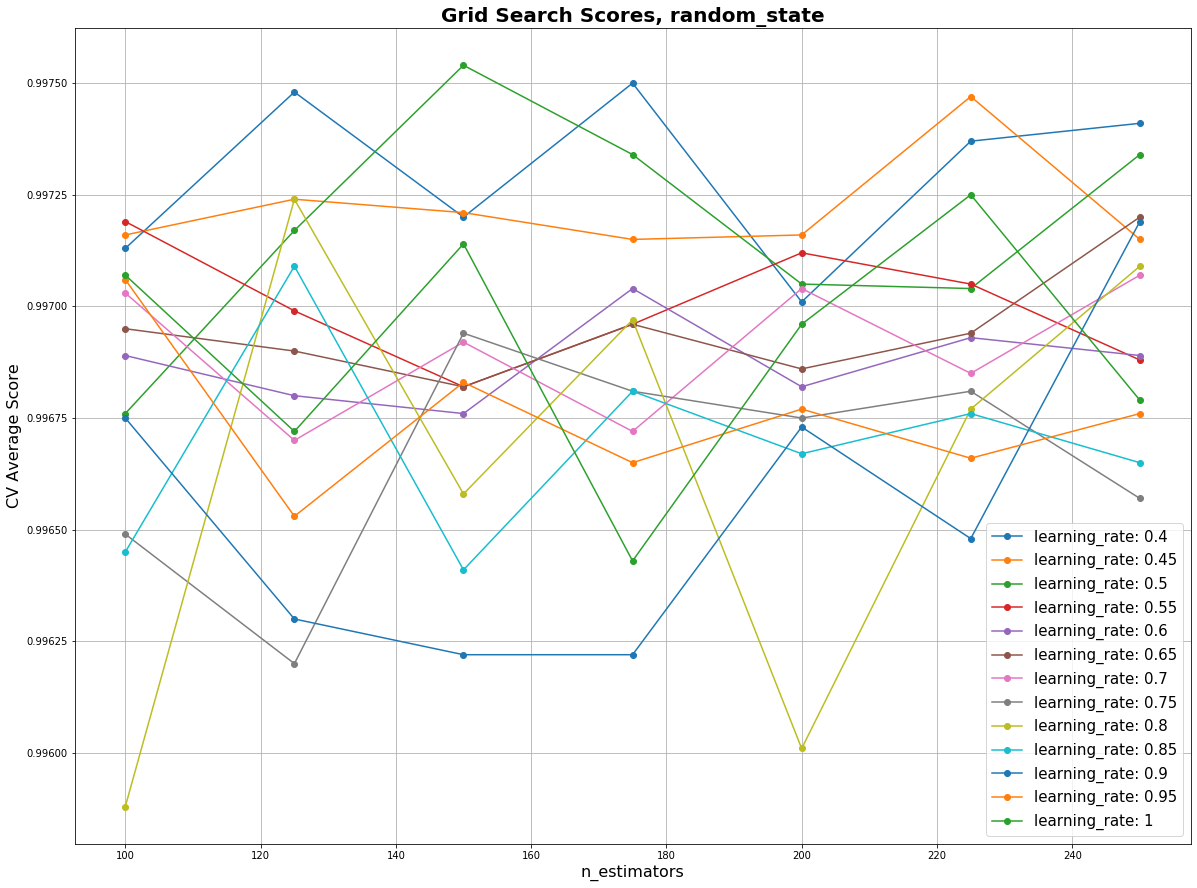

In [66]:
plot_grid_search(grid_ada_Tree5.cv_results_,  p_grid_Ada_Tree5['n_estimators'],p_grid_Ada_Tree5['learning_rate'], 'n_estimators','learning_rate')

In [67]:
print("Best Score: {}".format(grid_ada_Tree5.best_score_))
print("Best params: {}".format(grid_ada_Tree5.best_params_))
best_estimator_=grid_ada_Tree5.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree5.best_params_['learning_rate']
best_depth=4

Best Score: 0.9975400000000001
Best params: {'learning_rate': 0.5, 'n_estimators': 150}


###### weights = {0:1,1:10}

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",class_weight={0:1,1:10}, max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree5 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree5, scoring="accuracy", cv=5)
grid_ada_Tree5.fit(x_train_scale, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight={0: 1,
                                                                                              1: 10},
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None

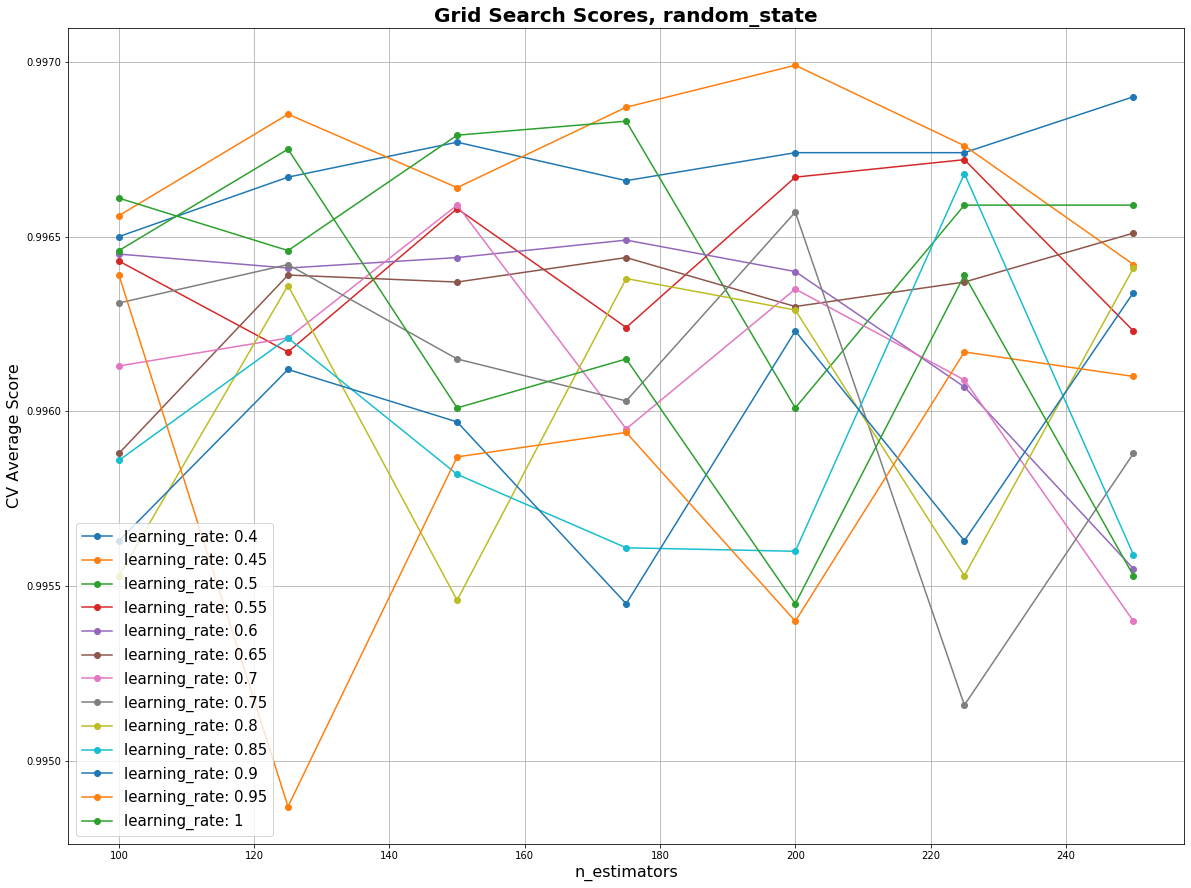

In [69]:
plot_grid_search(grid_ada_Tree5.cv_results_,  p_grid_Ada_Tree5['n_estimators'],p_grid_Ada_Tree5['learning_rate'], 'n_estimators','learning_rate')

In [70]:
print("Best Score: {}".format(grid_ada_Tree5.best_score_))
print("Best params: {}".format(grid_ada_Tree5.best_params_))
best_estimator_=grid_ada_Tree5.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree5.best_params_['learning_rate']
best_depth=4

Best Score: 0.9969899999999999
Best params: {'learning_rate': 0.45, 'n_estimators': 200}


Comme nous nous y attendions, utiliser un poids trop grand pour la classe minoriaire ne permet pas d'obtenir de très bons résultats.

###### weights = {0:1,1:2}

In [71]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",class_weight={0:1,1:2}, max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree6 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree5, scoring="accuracy", cv=5)
grid_ada_Tree6.fit(x_train_scale, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight={0: 1,
                                                                                              1: 2},
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,

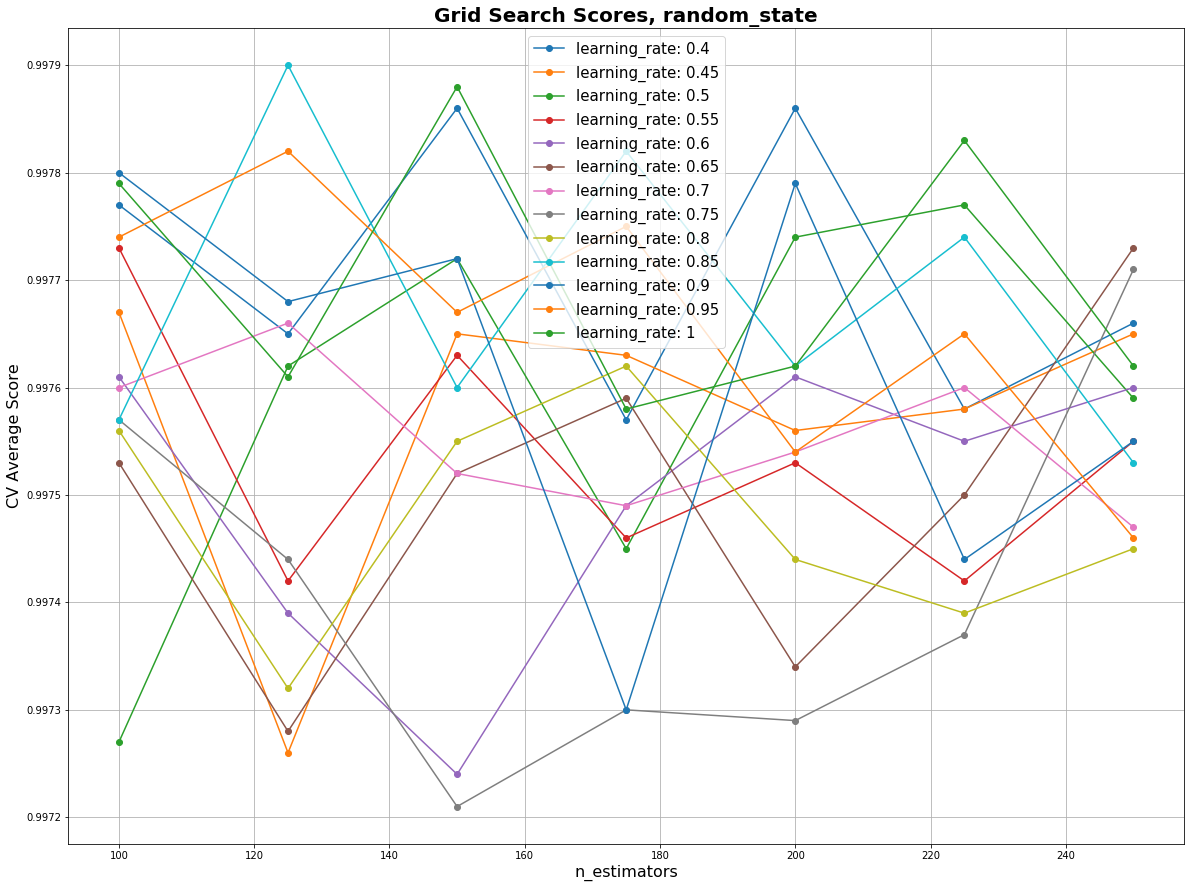

In [72]:
plot_grid_search(grid_ada_Tree6.cv_results_,  p_grid_Ada_Tree5['n_estimators'],p_grid_Ada_Tree5['learning_rate'], 'n_estimators','learning_rate')

In [73]:
print("Best Score: {}".format(grid_ada_Tree6.best_score_))
print("Best params: {}".format(grid_ada_Tree6.best_params_))
best_estimator_=grid_ada_Tree5.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree5.best_params_['learning_rate']
best_depth=4

Best Score: 0.9978999999999999
Best params: {'learning_rate': 0.85, 'n_estimators': 125}


__None of the weights tested get better results than the {0:1, 1:1}.__
In moreover, it seems that the possible spaces of the hyper-parameters are much more complex when we use different weights. 

##### Submit a result ( weights {0:1,1:2} )

In [74]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",class_weight={0:1,1:2}, max_depth=4, random_state=26, max_features='sqrt'),
                               n_estimators=125,learning_rate=0.85,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree_weights.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.995669464086

## Last research of hyperparameters

In [75]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

p_grid_Ada_Tree = {'n_estimators': [125,150,175,200,225,250],'learning_rate':[0.9,0.925,0.95,0.975,1]}

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree, scoring="accuracy", cv=5)
grid_ada_Tree.fit(x_train_scale, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

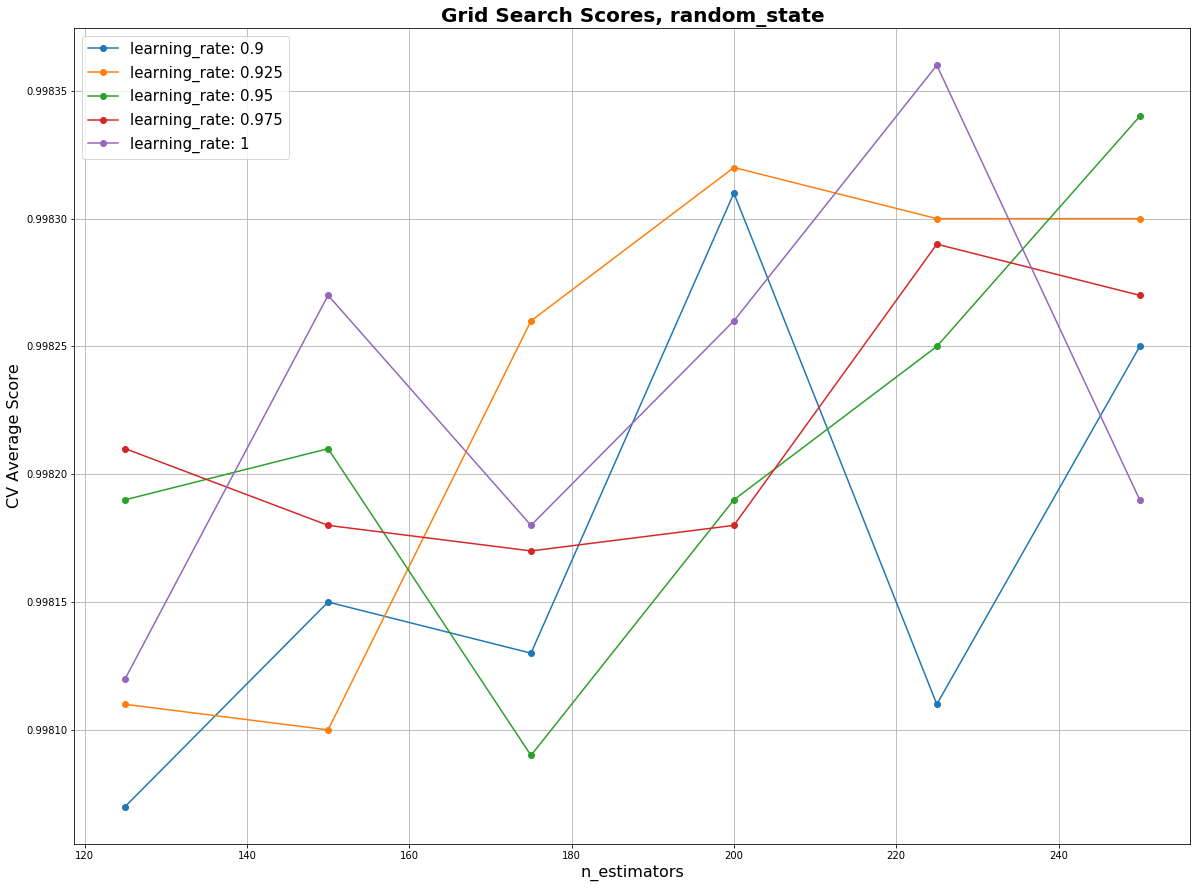

In [77]:
plot_grid_search(grid_ada_Tree.cv_results_,  p_grid_Ada_Tree['n_estimators'],p_grid_Ada_Tree['learning_rate'], 'n_estimators','learning_rate')

In [78]:
print("Best Score: {}".format(grid_ada_Tree.best_score_))
print("Best params: {}".format(grid_ada_Tree.best_params_))
best_estimator_=grid_ada_Tree.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree.best_params_['learning_rate']
best_depth=4

Best Score: 0.9983599999999999
Best params: {'learning_rate': 1, 'n_estimators': 225}


In [102]:
clf1= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99834


In [103]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99833


In [104]:
clf3= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99783


In [105]:
clf4= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99806


#### Submit a result

In [98]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=26, max_features='sqrt'),
                               n_estimators=225,learning_rate=1,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_final.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.997909167838

Paradoxically, we were getting better results before refining our research. This can be explained by the fact that GridSearchCV uses cross validation, and therefore the results obtained depend on how the data are distributed in the cross validation sets. Also, the score on hidden test data is worse than before. 

We could do further research on the best hyper-parameters, but this requires a lot of computational time, and I prefer to test other models in the next Notebook.


In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

## 9- Random Forest

### Random Forest with criterion Gini

RandomForest is similar to bagging, but at each node only a limited number of features are studied for the next split. This method is called "features bagging". It prevents the decision trees from being too correlated with each other. Indeed, some features are likely to appear in most of the generated trees. 

In [37]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt')
p_grid_RF = {'n_estimators': [25,50,75,100],'max_depth':[5,10,15,20,25,30]}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
best_estimator_RF=grid_RF.best_params_['n_estimators']
best_depth=grid_RF.best_params_['max_depth']

Best Score: 0.99785
Best params: {'max_depth': 15, 'n_estimators': 50}


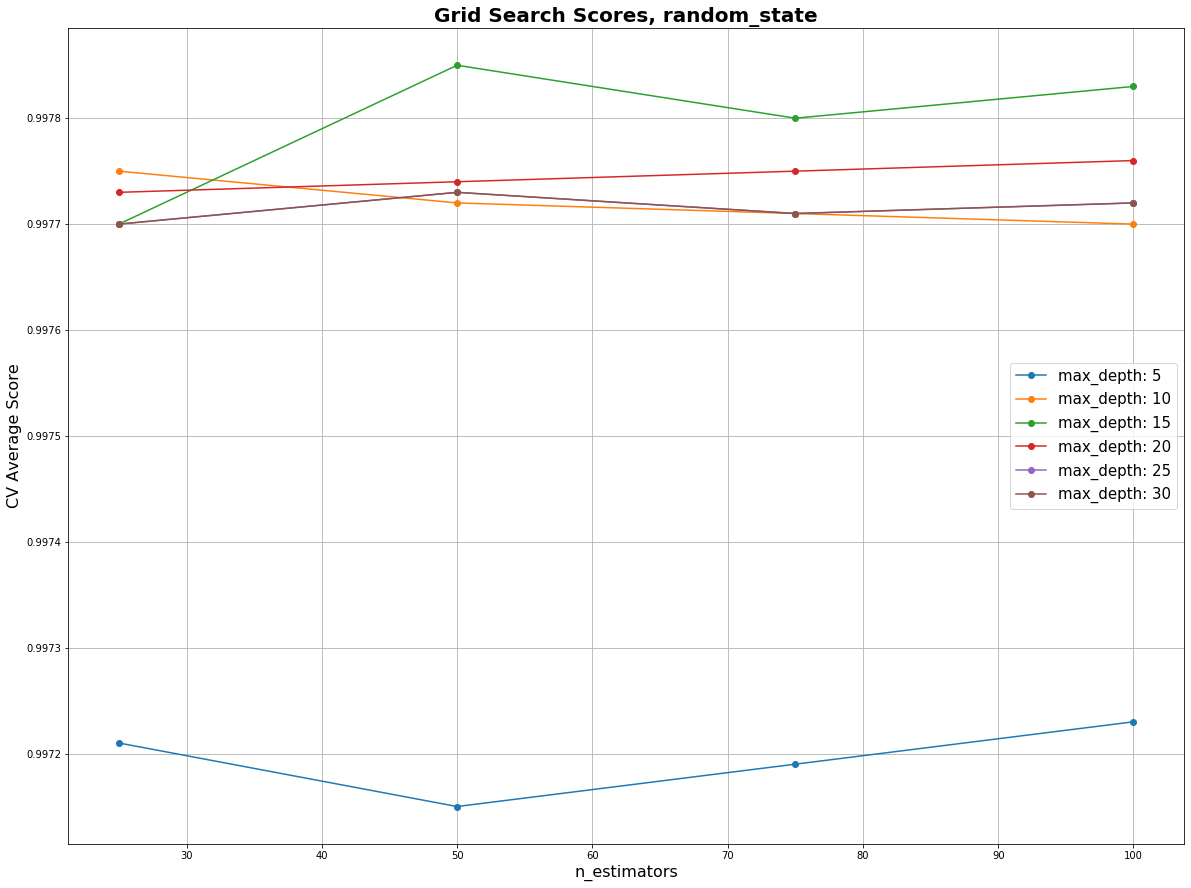

In [42]:
plot_grid_search(grid_RF.cv_results_,  p_grid_RF['n_estimators'],p_grid_RF['max_depth'], 'n_estimators','max_depth')

It seems that you have to choose a tree deep enough (>5), but taking a tree too deep doesn't change much. 
Similarly, choosing too many estimators does not seem to improve our results, and considerably increases the computation time.


Let's test our RandomForest best model on different types of data (scaled or not, balanced or not...)

In [59]:
best_estimator_RF=50
best_depth=15

In [60]:
RF1=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF1.fit(x_train, y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",RF1.score(x_train,y_train))
print("Test score:",RF1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99972
Test score: 0.9981


In [61]:
RF2=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",RF2.score(x_train_scale,y_train))
print("Test score :",RF2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99972
Test score : 0.9981


In [62]:
RF3=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",RF3.score(x_sample1,y_sample1))
print("Test score :",RF3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 0.9997922725384296
Test score : 0.99579


In [63]:
RF4=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",RF4.score(x_sample2,y_sample2))
print("Test score :",RF4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.9999653787564049
Test score : 0.99607


There is some overfitting, indeend the results of the train are a lot higher than those of the validation sample. 
Reducing the depth of the tree would be a good idea to improve the results of RandomForest.

#### Submit a result 

In [26]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=15,n_estimators=50)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_RF.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.997954974481

### Random Forest with criterion Entropy

Let's test another criterion to measure the quality of the split.

In [71]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt')
p_grid_RF = {'n_estimators': [25,50,75,100],'max_depth':[5,10,15,20,25,30]}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
best_estimator_RF=grid_RF.best_params_['n_estimators']
best_depth=grid_RF.best_params_['max_depth']

Best Score: 0.9976500000000001
Best params: {'max_depth': 20, 'n_estimators': 75}


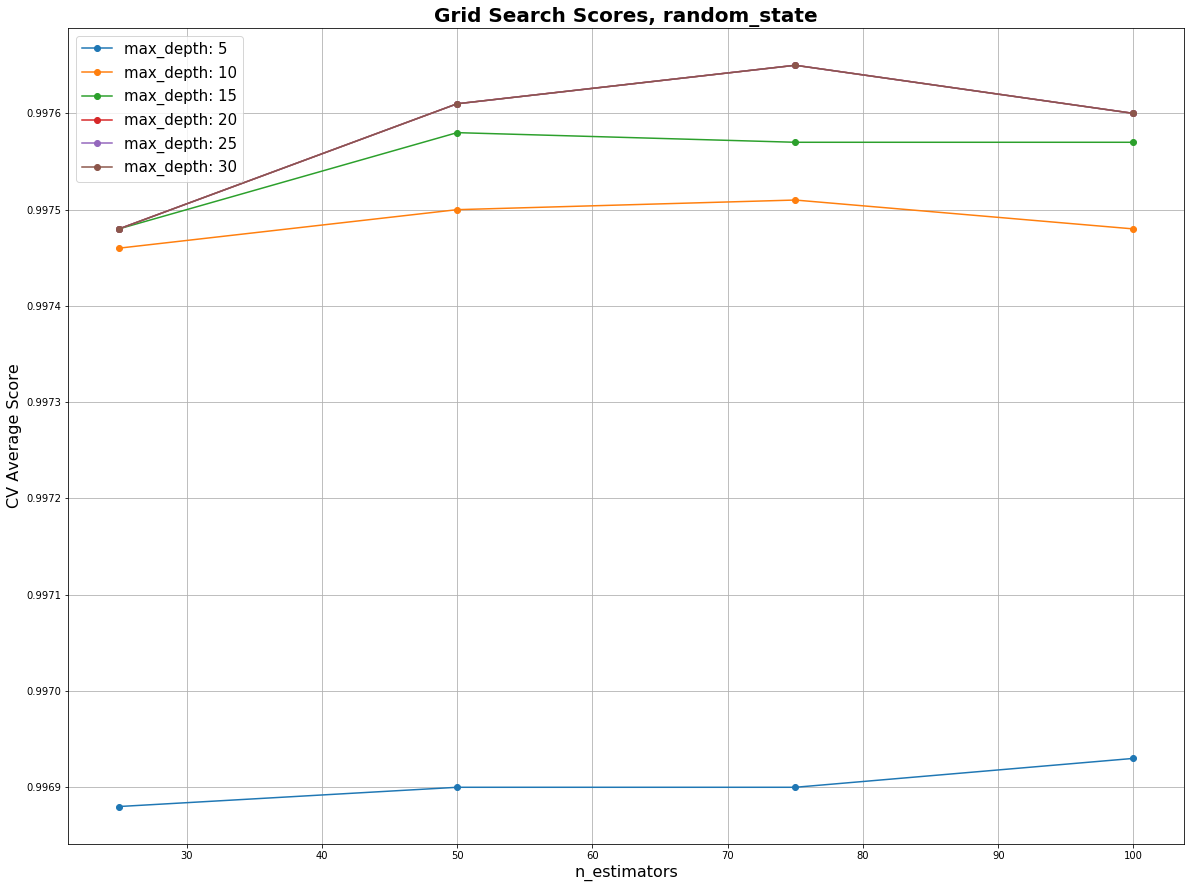

In [77]:
plot_grid_search(grid_RF.cv_results_,  p_grid_RF['n_estimators'],p_grid_RF['max_depth'], 'n_estimators','max_depth')

In [73]:
RF1=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF1.fit(x_train, y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",RF1.score(x_train,y_train))
print("Test score:",RF1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99998
Test score: 0.99814


In [74]:
RF2=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",RF2.score(x_train_scale,y_train))
print("Test score :",RF2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99998
Test score : 0.99814


In [75]:
RF3=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",RF3.score(x_sample1,y_sample1))
print("Test score :",RF3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 1.0
Test score : 0.996


In [76]:
RF4=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",RF4.score(x_sample2,y_sample2))
print("Test score :",RF4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.9967


#### Submit a Result

In [ ]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=20,n_estimators=75)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_RF_entropy.csv', ytest, fmt = '%1.0d', delimiter=',')

Score : 0.998002589281

It seems that we get slightly better results with entropy, which we decide to keep for the future.

### The Class Weight criteria

In [18]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt')
p_grid_RF = {'n_estimators': [25,50,75,100],'max_depth':[5,10,15,20,25,30],'class_weight':[{0:1,1:1},{0:1,1:5},{0:1,1:10}]}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
best_estimator_RF=grid_RF.best_params_['n_estimators']
best_depth=grid_RF.best_params_['max_depth']

Best Score: 0.9977199999999999
Best params: {'class_weight': {0: 1, 1: 1}, 'max_depth': 20, 'n_estimators': 100}


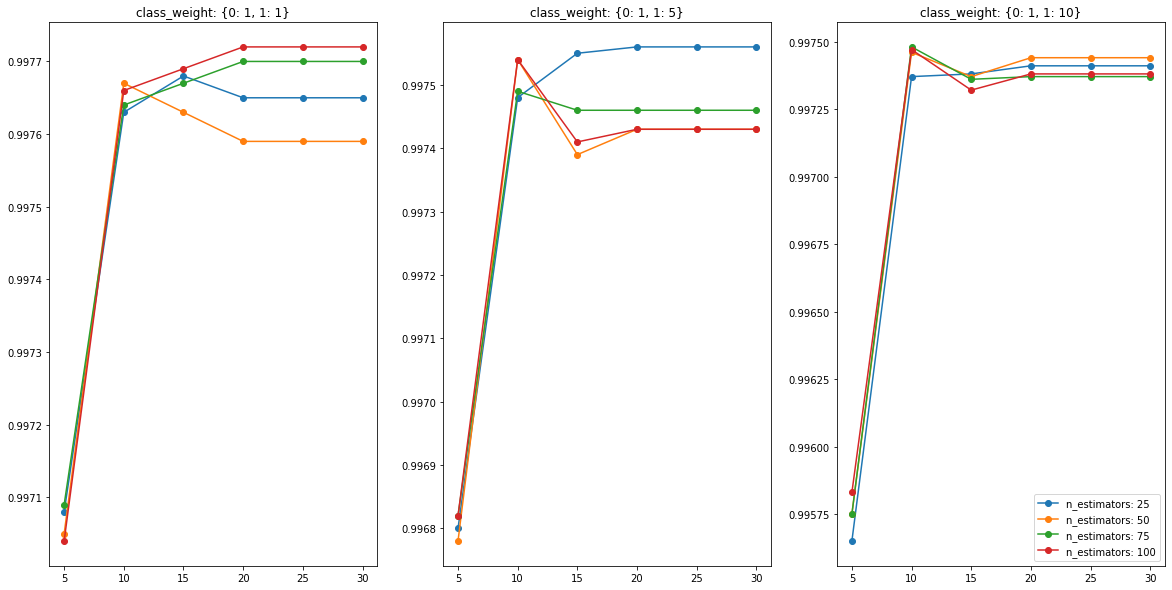

In [39]:
scores1=grid_RF.cv_results_['mean_test_score'][:24].reshape(6,4)
scores2=grid_RF.cv_results_['mean_test_score'][24:48].reshape(6,4)
scores3=grid_RF.cv_results_['mean_test_score'][48:].reshape(6,4)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('class_weight: {0: 1, 1: 1}')
for idx, val in enumerate(p_grid_RF['n_estimators']):
    plt.plot(p_grid_RF['max_depth'], scores1[:,idx], '-o', label= 'n_estimators' + ': ' + str(val))

plt.subplot(132)
plt.title('class_weight: {0: 1, 1: 5}')
for idx, val in enumerate(p_grid_RF['n_estimators']):
    plt.plot(p_grid_RF['max_depth'], scores2[:,idx], '-o', label= 'n_estimators' + ': ' + str(val))

plt.subplot(133)
plt.title('class_weight: {0: 1, 1: 10}')
for idx, val in enumerate(p_grid_RF['n_estimators']):
    plt.plot(p_grid_RF['max_depth'], scores3[:,idx], '-o', label= 'n_estimators' + ': ' + str(val))
    
plt.legend()
plt.show()


The best results are obtein with weight {0: 1, 1: 1}. Trying to balance the data set with this criterion contributes to over-fitting, so we decide to keep the weights {0:1, 1:1}.

## 10- AdaBoost

Adaboost generates a user-specified set of learners (otherwise it will randomly generate a set of weak learners). It will learn the weights of how to add these weak learners to be a strong learner. The weight of each learner is learned based on whether he predicts a sample correctly or not. The weight of a learner which predicts a sample badly is reduced. This process is repeated until the algorithme converges.

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()
p_grid_ada = {'n_estimators': [50,100,150,200,250], 'learning_rate':[0.2,0.4,0.6,0.8,1]}   

grid_ada = GridSearchCV(estimator=ada, param_grid=p_grid_ada, scoring="accuracy", cv=5)
grid_ada.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_ada.best_score_))
print("Best params: {}".format(grid_ada.best_params_))
best_estimator_ada=grid_ada.best_params_['n_estimators']
best_lr=grid_ada.best_params_['learning_rate']

Best Score: 0.9978999999999999
Best params: {'learning_rate': 0.4, 'n_estimators': 250}


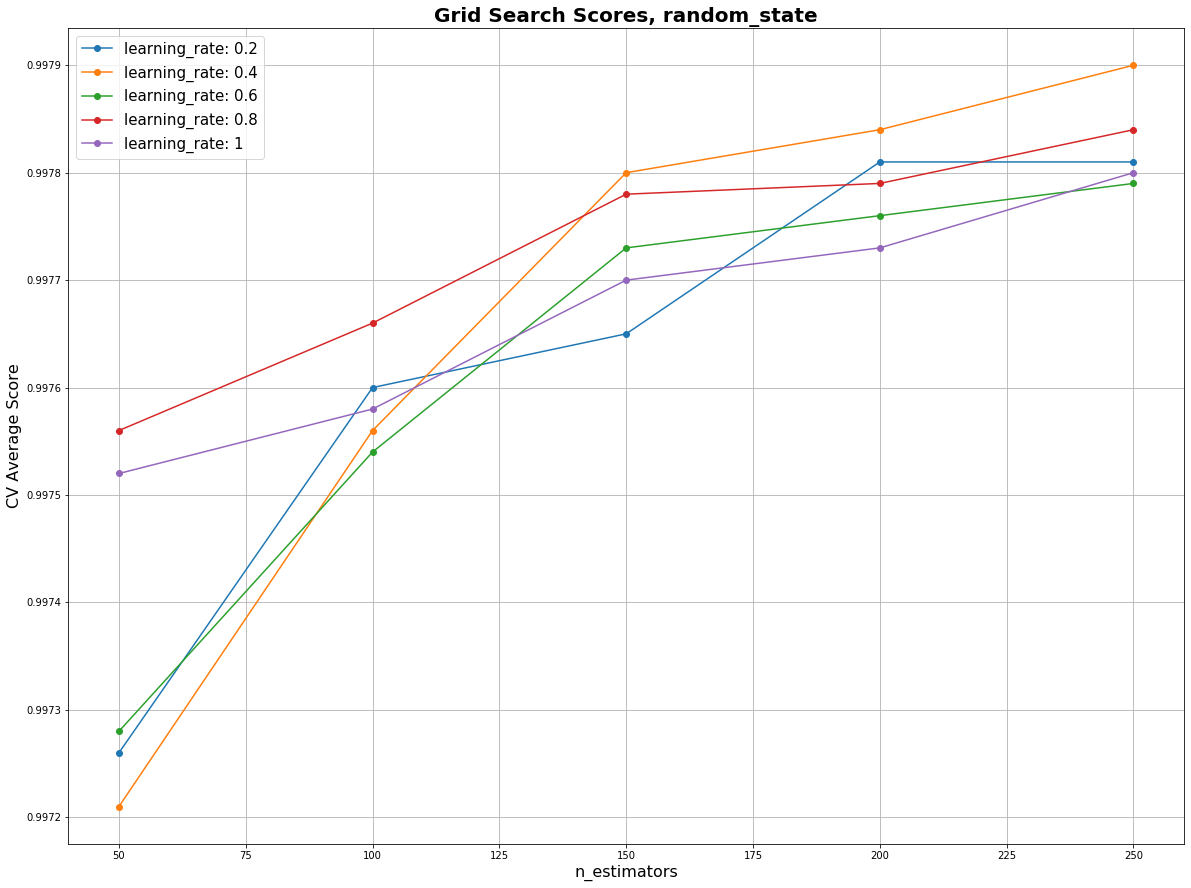

In [44]:
plot_grid_search(grid_ada.cv_results_,  p_grid_ada['n_estimators'],p_grid_ada['learning_rate'], 'n_estimators','learning_rate')

#### Submit a Result 

In [37]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=AdaBoostClassifier(n_estimators=200, learning_rate=0.55)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaBoost2.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.997770542471

The scores clearely increases when the number of estimator increases. The smaller learning rates seems to get better in the ranking when the number of estimators is large.


Let's deepen our research around these values.

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()
p_grid_ada2 = {'n_estimators': [175,200,225,250], 'learning_rate':[0.25,0.3,0.35,0.4,0.45,0.5,0.55]}   

grid_ada2 = GridSearchCV(estimator=ada, param_grid=p_grid_ada2, scoring="accuracy", cv=5)
grid_ada2.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_ada2.best_score_))
print("Best params: {}".format(grid_ada2.best_params_))

Best Score: 0.99793
Best params: {'learning_rate': 0.45, 'n_estimators': 250}


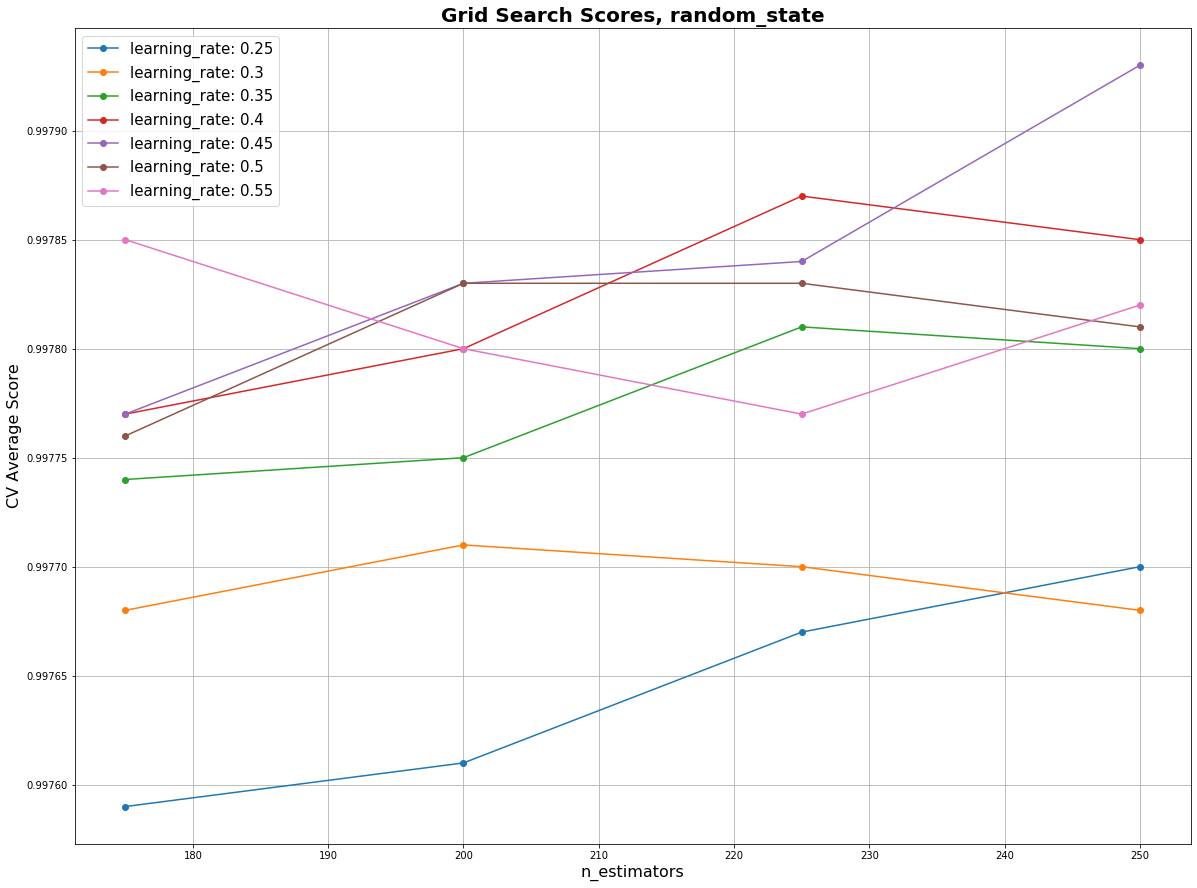

In [31]:
best_estimator_ada=grid_ada2.best_params_['n_estimators']
best_lr=grid_ada2.best_params_['learning_rate']
plot_grid_search(grid_ada2.cv_results_,  p_grid_ada2['n_estimators'],p_grid_ada2['learning_rate'], 'n_estimators','learning_rate')

Let's test our best AdaBoost model on different types of data (scaled or not, balanced or not...)

In [32]:
ada1=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada1.fit(x_train,y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",ada1.score(x_train,y_train))
print("Test score :",ada1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99864
Test score : 0.99797


In [33]:
ada2=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada2.fit(x_train_scale,y_train)
print("Imbalanced Dataset scaled")
print("Training score :",ada2.score(x_train_scale,y_train))
print("Test score :",ada2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99864
Test score : 0.99797


In [34]:
ada3=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada3.fit(x_sample1,y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",ada3.score(x_sample1,y_sample1))
print("Test score :",ada3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 0.9980606060606061
Test score : 0.99618


In [35]:
ada4=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada4.fit(x_sample2,y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",ada4.score(x_sample2,y_sample2))
print("Test score :",ada4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.997991341991342
Test score : 0.99626


#### Submit a Result 

In [36]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaBoost1.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.997780788694

The score increases, but it's a very small increase.

### Look for best hyperparameters

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()
p_grid_ada3 = {'n_estimators': [200,225,250], 'learning_rate':[0.4,0.425,0.45,0.475,0.5,0.525,0.55,0.575,0.6]}   

grid_ada3 = GridSearchCV(estimator=ada, param_grid=p_grid_ada3, scoring="accuracy", cv=5)
grid_ada3.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_ada3.best_score_))
print("Best params: {}".format(grid_ada3.best_params_))

Best Score: 0.9980800000000001
Best params: {'learning_rate': 0.55, 'n_estimators': 200}


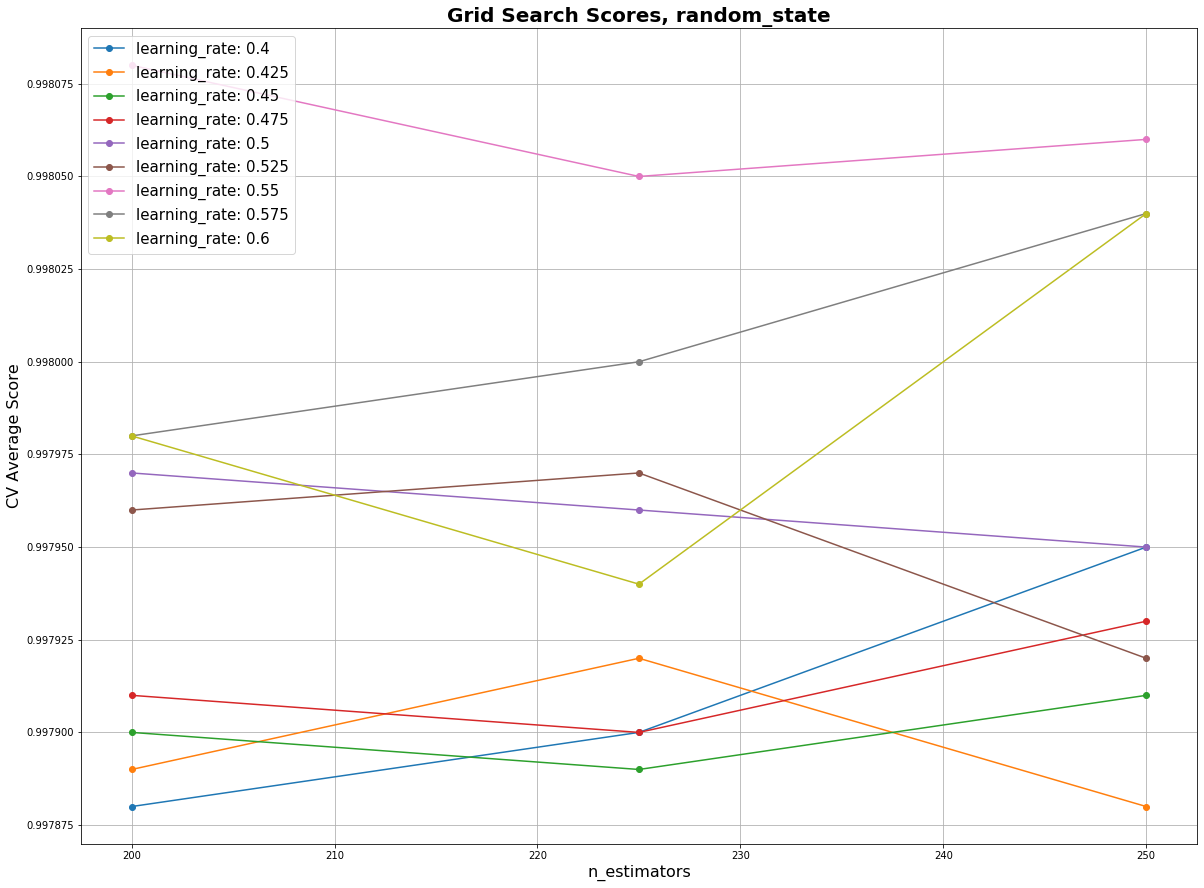

In [15]:
best_estimator_ada=grid_ada3.best_params_['n_estimators']
best_lr=grid_ada3.best_params_['learning_rate']
plot_grid_search(grid_ada3.cv_results_,  p_grid_ada3['n_estimators'],p_grid_ada3['learning_rate'], 'n_estimators','learning_rate')

In [16]:
ada1=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada1.fit(x_train,y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",ada1.score(x_train,y_train))
print("Test score :",ada1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99864
Test score : 0.99799


In [17]:
ada2=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada2.fit(x_train_scale,y_train)
print("Imbalanced Dataset scaled")
print("Training score :",ada2.score(x_train_scale,y_train))
print("Test score :",ada2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99864
Test score : 0.99799


In [40]:
ada3=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada3.fit(x_sample1,y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",ada3.score(x_sample1,y_sample1))
print("Test score :",ada3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 0.9976815806775321
Test score : 0.99639


In [41]:
ada4=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada4.fit(x_sample2,y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",ada4.score(x_sample2,y_sample2))
print("Test score :",ada4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.9985466625142738
Test score : 0.99682


##### Submit a result

In [42]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=AdaBoostClassifier(n_estimators=200, learning_rate=0.55)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaBoost3.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.996956269121

Once agin we notice that looking too precisely for the best hyperparameters doesn't always get better results. Indeed, there is randomness in cross validation used in GridSearchCV.

## AdaBoost on Random Forest

In order to limit the computationnal time, I have chosen to fix the number of estimators in Random Forest at 20. 
We have seen in the previous models that Random Forest doesn't improve a lot when the number of estimators increase. 

We also choose to limit ourselves to small depths without carrying out tests, we indeed noticed in the previous models that small depths were better. 

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

depth=[2,4,6,8]
p_grid_Ada_RF = {'n_estimators': [100,150,200],'learning_rate':[0.9,0.95,0.98],}
score_ada_rf=[]
parameters_ada_rf=[]
for i in depth:
    model = AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=i, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
    grid_ada_RF = GridSearchCV(estimator=model, param_grid=p_grid_Ada_RF, scoring="accuracy", cv=5)
    grid_ada_RF.fit(x_train_scale, y_train)
    score_ada_rf.append(grid_ada_RF.best_score_)
    parameters_ada_rf.append(grid_ada_RF.best_params_)
    

Text(0.5, 1.0, 'Best GridSearch Score according to max_depth')

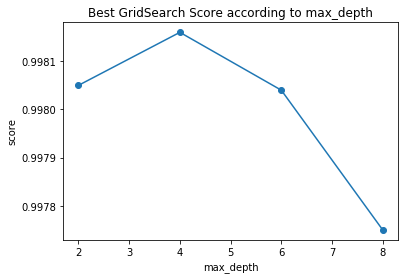

In [14]:
depth=[2,4,6,8]
best_estimator_RF=20
idx=score_ada_rf.index(max(score_ada_rf))
best_depth=depth[idx]
estimators_=[dic['n_estimators'] for dic in parameters_ada_rf]
lr_=[dic['learning_rate'] for dic in parameters_ada_rf]
best_estimator_=estimators_[idx]
best_lr_=lr_[idx]

plt.figure()
plt.plot(depth,score_ada_rf,marker='o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Best GridSearch Score according to max_depth')

The best max_depth is 4. We decide to work with this depth for the end of the notebook.

Text(0.5, 1.0, 'Best GridSearch nb_estimator according to max_depth')

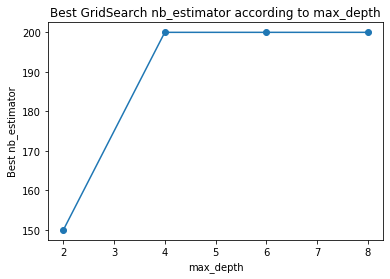

In [9]:
plt.figure()
plt.plot(depth,estimators_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best nb_estimator')
plt.title('Best GridSearch nb_estimator according to max_depth')

It seems that deeper trees need more estimators in adaBoost to get good results.

Text(0.5, 1.0, 'Best GridSearch learning rate according to max_depth')

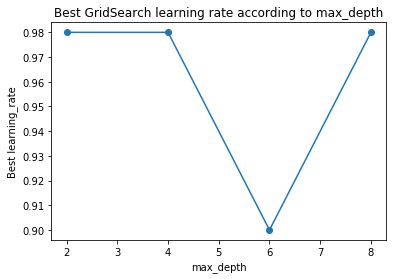

In [10]:
plt.figure()
plt.plot(depth,lr_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best learning_rate')
plt.title('Best GridSearch learning rate according to max_depth')

Let's test this first model :

In [25]:
clf1= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99839


In [26]:
clf2= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99836


In [27]:
clf3= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99729


In [28]:
clf4= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99778


Once again, we note that balanced data perform worse than unbalanced data.  SMOTE performs even worse than OverSampling. Indeed, the SMOTE algorithm generates noise to which AdaBoost is particularly sensitive. 


So we decided to test lower learnings_rate. We also decided to test the entropy criterion of the random forest.
We fixed max_depth = 4 because the computationnak time for this research is very long, and we've already seen that a simple weak classifier prevents over-fitting.

#### Submit a result

In [40]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf2= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=200,learning_rate=0.98,algorithm="SAMME")
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_challenge_student_ada_RF1.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998459450272

I decided to use the criterion entropy given the previous results on RandomForest and on AdaBoost on DecisionTreeClassifier.

### Entropy criterion

In [16]:
p_grid_Ada_RF2 = {'n_estimators': [100,150,200,250],'learning_rate':[0.3,0.5,0.7,0.9]}

model = AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_RF2 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_RF2, scoring="accuracy", cv=5)
grid_ada_RF2.fit(x_train_scale, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=RandomForestClassifier(bootstrap=True,
                                                                                ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                max_samples=None,
                                                                                min_impurity_decrease=0.0,
            

In [17]:
print("Best Score: {}".format(grid_ada_RF2.best_score_))
print("Best params: {}".format(grid_ada_RF2.best_params_))
best_estimator_=grid_ada_RF2.best_params_['n_estimators']
best_lr_adaTree=grid_ada_RF2.best_params_['learning_rate']
best_depth=4

Best Score: 0.9983700000000001
Best params: {'learning_rate': 0.5, 'n_estimators': 200}


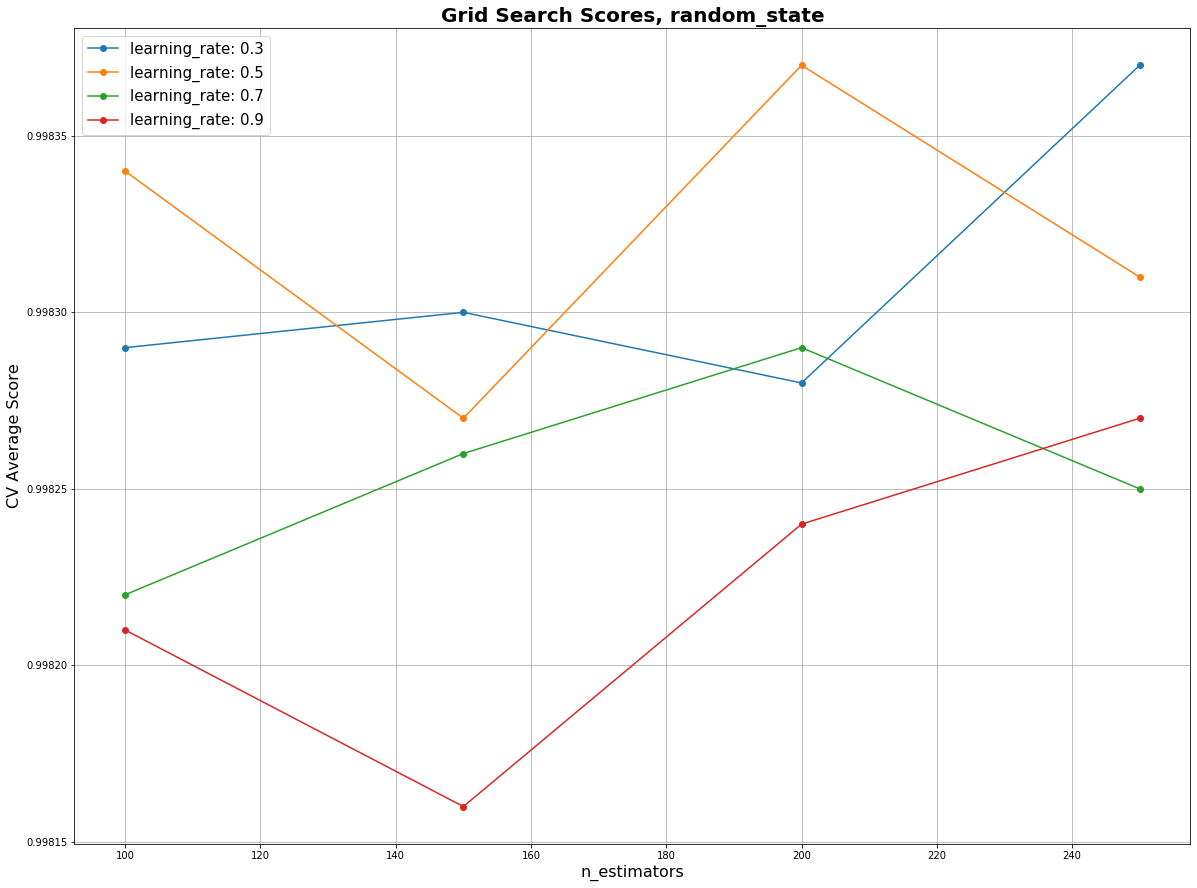

In [19]:
plot_grid_search(grid_ada_RF2.cv_results_,  p_grid_Ada_RF2['n_estimators'],p_grid_Ada_RF2['learning_rate'], 'n_estimators','learning_rate')

In [20]:
clf1= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99846


In [21]:
clf2= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99838


In [22]:
clf3= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.9974


In [23]:
clf4= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99762


#### Submit a result

In [41]:
clf= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=200,learning_rate=0.5,algorithm="SAMME")
clf.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_challenge_adaRF.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998449204049

## Area for improvement : 

First of all, we could look for the best hyperparameters with more details. 

Then we could use a large number of estimator in randomForest. Using randomForest with more estimators gives very good results as shown in the tests below. However, I'm limited by the computational capabilities of my computer, and training a single model takes about a day. Indeed it is necessary to generate nb_estimators_RanfomForest x nb_estimators_AdaBoost decision trees for each training.

In [ ]:
clf2=AdaBoostClassifier(RandomForestClassifier(max_depth=4,criterion="gini",class_weight={0:1,1:1},max_features='sqrt',n_estimators=50),n_estimators=225,learning_rate=0.55,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree-50-225-0.55.csv', ytest, fmt = '%1.0d', delimiter=',')

Score : 0.998517914014




I noticed that if we decide to use a large number of estimators for Random Forest, it is better to use a small learning rate :

In [ ]:
clf2=AdaBoostClassifier(RandomForestClassifier(max_depth=4,criterion="entropy",class_weight={0:1,1:1},max_features='sqrt',n_estimators=75),n_estimators=225,learning_rate=0.825,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree-75-225-0825.csv', ytest, fmt = '%1.0d', delimiter=',')

Score : 0.998426903447

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf2=AdaBoostClassifier(RandomForestClassifier(criterion="entropy", max_depth=4, max_features='sqrt',n_estimators=75),
                               n_estimators=225,learning_rate=1,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree_75_225_1.csv', ytest, fmt = '%1.0d', delimiter=',')

Score : 0.99844257414

# CONCLUSION

Stats| .
- |-: 
Score  | 0.998598678358%
Ranking | 48/126 

What was interesting about this challenge was that it was the first time we had to deal with only the raw data. 
Our strategy was pretty standard, 
We started by training simple models at the beginning. 
However, we realized from the start that it was going to be played to the nearest thousandth. 


When we looked at the data at the beginning, we figured the big challenge would be to deal with unbalanced data. We figured that a lot of models were going to return the 0 label too often. 
That's why we took action on our data, using oversampling on class 0, undersampling on class 1, or even both at the same time. We also tried giving different weights to the two classes with the parameter class_weights that most methods have. 
All this was not very useful in the end. We have indeed noticed that overfitting was very rare here, there shouldn't be many outliers. 

So the interest was to find a model that was complex enough, given the number of data we had, and the high number of features that each one has. 

To do that, we split the task in two: 

- Marine worked in detail on the decision trees, with testing of several criteria such as GINI or cross-entropy, with Bagging testing, performance improvement with AdaBoost, and systematic search for the best possible parameters with cross-validation. 

- Paul focused on linear models, neural networks, before focusing on decision-tree-based algorithms that uses a gradient boosting framework such as xgboost. Finally, in order to improve the most possble score, he tried the VotingClassifier and Stacking ensemble methods which gave the final score.


What could have been improved : 

- We regret to have discovered more complex methods than those seen too late in class. We focused mainly on the methods in the course, when we could have moved faster towards more complex methods like xgboost, and the use of set methods. 

- We could have perform more clever data augmentation... In fact, each data represents score A/score B/score A-B where A and B are images and could have been transformed in score B/score A/score A-B but it's unfortunately too late to do this augmentation